# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [2]:
import math
def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

In [3]:
d = 3  
n = 4
sparsity = nCr(n+d, d)

x_max = 1#10 #this number excluded
x_min = -1#-10
x_step = 0.01#0.1
a_max = 10 #this number excluded
a_min = -10
a_step = 0.1

n_jobs = -3


data_size = 100 #for loading lambda models

#specify interpretation net structure
optimizer = 'adam'
dropout = 0
epochs = 100
batch_size = 128
interpretation_network_layers = [2048]

random_evaluation_dataset_size = 500

#lambda net specifications for loading (need to be set according to lambda net training to load correct weights)
epochs_lambda = 200
batch_lambda = 64
lambda_network_layers = [5*sparsity]
optimizer_lambda = '_' + 'SGD'


lambda_dataset_size = 1000

#set if multi_epoch_analysis should be performed
multi_epoch_analysis = True
each_epochs_save_lambda = 10 #None if no checkpointing (otherwise set according to lambda-net training)
epoch_start = 0 #use to skip first epochs in multi_epoch_analysis

#set if samples analysis should be performed
samples_list = None#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 

evaluate_with_real_function = False
consider_labels_training = False

same_training_all_lambda_nets = False
fixed_seed_lambda_training = True

In [4]:
##############DO NOT CHANGE###################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n] 

RANDOM_SEED = 42

epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1)

advanced_metric_dataset_size = 10#200

use_gpu = False
if use_gpu:
    gpu_numbers = '0'
else:
    gpu_numbers = ''

if fixed_seed_lambda_training:
    seed_shuffle_string = '_SeedMethod'
elif not fixed_seed_lambda_training:
    seed_shuffle_string = '_NoSeedMethod'

if same_training_all_lambda_nets:
    training_string = '_same'
else:
    training_string = '_diverse'

layers_str = ''.join([str(neurons) + '-' for neurons in lambda_network_layers])

structure = '_' + layers_str + str(epochs_lambda) + 'e' + str(batch_lambda) + 'b' + optimizer_lambda
filename = seed_shuffle_string + '_' + str(RANDOM_SEED) + structure

interpretation_network_string = 'drop' + str(dropout) + 'e' + str(epochs) + 'b' + str(batch_size) + '_' + str(interpretation_network_layers)



## Imports

In [5]:
import ttg
from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 

import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers
import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

import tensorflow as tf
import random 
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings('ignore')

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

In [114]:
#Utility Functions

ALPHABET = \
  "0123456789abcdefghijklmnopqrstuvwxyz"

def encode (n):
    try:
        return ALPHABET [n]
    except IndexError:
        raise Exception ("cannot encode: %s" % n)
        
def dec_to_base (dec = 0, base = 16):
    if dec < base:
        return encode (dec)
    else:
        return dec_to_base (dec // base, base) + encode (dec % base)

def return_float_tensor_representation(some_representation, dtype=tf.float32):
    if tf.is_tensor(some_representation):
        some_representation = tf.dtypes.cast(some_representation, dtype) 
    else:
        some_representation = tf.convert_to_tensor(some_representation)
        some_representation = tf.dtypes.cast(some_representation, dtype) 
        
    if not tf.is_tensor(some_representation):
        raise SystemExit('Given variable is no instance of ' + str(dtype) + ':' + str(some_representation))
     
    return some_representation


def return_numpy_representation(some_representation):
    if isinstance(some_representation, pd.DataFrame):
        some_representation = some_representation.values
        
    if isinstance(some_representation, list):
        some_representation = np.array(some_representation)
    
    if not isinstance(some_representation, np.ndarray):
        raise SystemExit('Given variable is no instance of ' + str(np.ndarray) + ':' + str(some_representation))
    
    return some_representation

def mergeDict(dict1, dict2):
    #Merge dictionaries and keep values of common keys in list
    newDict = {**dict1, **dict2}
    for key, value in newDict.items():
        if key in dict1 and key in dict2:
            if isinstance(dict1[key], list) and isinstance(value, list):
                newDict[key] = dict1[key]
                newDict[key].extend(value)
            elif isinstance(dict1[key], list) and not isinstance(value, list):
                newDict[key] = dict1[key]
                newDict[key].extend([value])
            elif not isinstance(dict1[key], list) and isinstance(value, list):
                newDict[key] = [dict1[key]]
                newDict[key].extend(value)
            else:
                newDict[key] = [dict1[key], value]
    return newDict

def return_callbacks_from_string(callback_string_list):
    callbacks = [] if len(callback_string_list) > 0 else None
    if 'plot_losses_callback' in callback_string_list:
        callbacks.append(PlotLossesKerasTF())
    if 'reduce_lr_loss' in callback_string_list:
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=epochs/10, verbose=0, min_delta=0, mode='min') #epsilon
        callbacks.append(reduce_lr_loss)
    if 'early_stopping' in callback_string_list:
        earlyStopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0, verbose=0, mode='min')
        callbacks.append(earlyStopping)
        
    if not multi_epoch_analysis and samples_list == None: 
        callbacks.append(TQDMNotebookCallback())
        
    return callbacks

### Generate List of Monomial Identifiers

In [8]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)



List length: 256
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0013', '0020', '0021', '0022', '0023', '0030', '0031', '0032', '0033', '0100', '0101', '0102', '0103', '0110', '0111', '0112', '0113', '0120', '0121', '0122', '0123', '0130', '0131', '0132', '0133', '0200', '0201', '0202', '0203', '0210', '0211', '0212', '0213', '0220', '0221', '0222', '0223', '0230', '0231', '0232', '0233', '0300', '0301', '0302', '0303', '0310', '0311', '0312', '0313', '0320', '0321', '0322', '0323', '0330', '0331', '0332', '0333', '1000', '1001', '1002', '1003', '1010', '1011', '1012', '1013', '1020', '1021', '1022', '1023', '1030', '1031', '1032', '1033', '1100', '1101', '1102', '1103', '1110', '1111', '1112', '1113', '1120', '1121', '1122', '1123', '1130', '1131', '1132', '1133', '1200', '1201', '1202', '1203', '1210', '1211', '1212', '1213', '1220', '1221', '1222', '1223', '1230', '1231', '1232', '1233', '1


List length: 35
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0020', '0021', '0030', '0100', '0101', '0102', '0110', '0111', '0120', '0200', '0201', '0210', '0300', '1000', '1001', '1002', '1010', '1011', '1020', '1100', '1101', '1110', '1200', '2000', '2001', '2010', '2100', '3000']


## Loss/Error functions

In [9]:
#Manual TF Loss function for comparison with polynomials on function value basis

def calculate_mae_fv(polynomial_true_pred):
    polynomial_true = polynomial_true_pred[0]
    polynomial_pred = polynomial_true_pred[1]
    
    global lambda_train_input
    lambda_input = lambda_train_input
    
    for index, lambda_input_entry in enumerate(lambda_input):

        value_without_coefficient = np.array([reduce(lambda x, y: x*y, [lambda_input_value**int(coefficient_multiplier) for coefficient_multiplier, lambda_input_value in zip(coefficient_multiplier_term, lambda_input_entry)]) for coefficient_multiplier_term in list_of_monomial_identifiers], dtype='float32')
            
        polynomial_true_value_per_term = tf.vectorized_map(lambda x: x[0]*x[1], (value_without_coefficient, polynomial_true))
        polynomial_true_fv = tf.reduce_sum(polynomial_true_value_per_term)

        polynomial_pred_value_per_term = tf.vectorized_map(lambda x: x[0]*x[1], (value_without_coefficient, polynomial_pred))
        polynomial_pred_fv = tf.reduce_sum(polynomial_pred_value_per_term)
        
        if index == 0:   
            result = tf.math.abs(tf.math.subtract(polynomial_true_fv, polynomial_pred_fv))
        else:           
            current_valiue = tf.math.abs(tf.math.subtract(polynomial_true_fv, polynomial_pred_fv))
            result = tf.math.add(result, current_valiue)    
            
    return  tf.math.divide(result, lambda_input.shape[0]) #tf.random.uniform(shape=[1], minval=0.1, maxval=10.0)

def mean_absolute_error_tf_fv(y_true, y_pred):
    return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_fv, (y_true, y_pred)))


In [ ]:
np.array([reduce(lambda x, y: x*y, [evaluation_value**int(coefficient_multiplier) for coefficient_multiplier, evaluation_value in zip(coefficient_multiplier_term, evaluation_entry)]) for coefficient_multiplier_term in list_of_monomial_identifiers], dtype='float32')


In [32]:
evaluation_entry = lambda_train_input[0]
print(evaluation_entry)
coefficient_multiplier_term = [1,2,3,4]
print(evaluation_entry)
[evaluation_value**int(coefficient_multiplier) for coefficient_multiplier, evaluation_value in zip(coefficient_multiplier_term, evaluation_entry)]


[[-0.34 -0.68  0.88  0.64]
 [ 0.85  0.73  0.25 -0.37]
 [ 0.57 -0.76 -0.52 -0.57]
 ...
 [ 0.28  0.01  0.55  0.22]
 [ 0.59  0.34  0.16 -0.88]
 [ 0.92  0.86  0.67 -0.14]]
[[-0.34 -0.68  0.88  0.64]
 [ 0.85  0.73  0.25 -0.37]
 [ 0.57 -0.76 -0.52 -0.57]
 ...
 [ 0.28  0.01  0.55  0.22]
 [ 0.59  0.34  0.16 -0.88]
 [ 0.92  0.86  0.67 -0.14]]


[array([-0.34, -0.68,  0.88,  0.64]),
 array([0.7225, 0.5329, 0.0625, 0.1369]),
 array([ 0.185193, -0.438976, -0.140608, -0.185193]),
 array([2.0736000e-04, 4.0960000e-05, 8.4934656e-01, 4.9787136e-01])]

In [ ]:
calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers)(polynomial_true, polynomial_pred, lambda_fv)

In [57]:
list_of_monomial_identifiers_numbers

<tf.Tensor: shape=(35, 4), dtype=float64, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 2.],
       [0., 0., 0., 3.],
       [0., 0., 1., 0.],
       [0., 0., 1., 1.],
       [0., 0., 1., 2.],
       [0., 0., 2., 0.],
       [0., 0., 2., 1.],
       [0., 0., 3., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 1.],
       [0., 1., 0., 2.],
       [0., 1., 1., 0.],
       [0., 1., 1., 1.],
       [0., 1., 2., 0.],
       [0., 2., 0., 0.],
       [0., 2., 0., 1.],
       [0., 2., 1., 0.],
       [0., 3., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 2.],
       [1., 0., 1., 0.],
       [1., 0., 1., 1.],
       [1., 0., 2., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.],
       [1., 2., 0., 0.],
       [2., 0., 0., 0.],
       [2., 0., 0., 1.],
       [2., 0., 1., 0.],
       [2., 1., 0., 0.],
       [3., 0., 0., 0.]])>

In [ ]:
tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))


In [64]:
evaluation_entry = tf.constant(lambda_train_input[0][0], tf.float32)
print(evaluation_entry)
coefficient_multiplier_term = tf.constant([1.0,2.0,3.0,4.0], tf.float32)
print(coefficient_multiplier_term)
calculate_value_without_coefficient_wrapper(evaluation_entry)(coefficient_multiplier_term)

tf.Tensor([-0.34 -0.68  0.88  0.64], shape=(4,), dtype=float32)
tf.Tensor([1. 2. 3. 4.], shape=(4,), dtype=float32)
calculate_value_without_coefficient_wrapper
(4,)
(4,)


<tf.Tensor: shape=(), dtype=float32, numpy=-0.017974824>

array([ 1.02843450e+01, -2.43461197e+00,  9.36263804e-01, -2.26335769e-01,
       -1.29452200e+01, -5.79299579e-01,  2.78989860e-01,  7.56058328e-01,
        9.47982839e-01,  8.96193137e-01,  3.11938798e+00,  3.08603460e+00,
        3.12727280e-02,  4.35735082e-01,  2.96634370e-01, -2.70302487e-01,
        1.45772577e+00,  1.67981372e-01,  8.97095978e-01, -8.94430634e-02,
        5.52497645e+00, -5.49232391e-01,  3.70975567e-03,  2.29478658e+00,
       -1.22997219e-01, -8.06895410e-01, -1.86962550e-01, -2.41871049e-01,
        7.98170054e-01, -4.36566528e-01,  1.77331870e+00,  2.97839577e-02,
        5.82040971e-01, -4.25621960e-01, -6.21066911e-02])

In [ ]:
polynomial_pred 

In [71]:
list_of_monomial_identifiers_numbers

<tf.Tensor: shape=(35, 4), dtype=float64, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 2.],
       [0., 0., 0., 3.],
       [0., 0., 1., 0.],
       [0., 0., 1., 1.],
       [0., 0., 1., 2.],
       [0., 0., 2., 0.],
       [0., 0., 2., 1.],
       [0., 0., 3., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 1.],
       [0., 1., 0., 2.],
       [0., 1., 1., 0.],
       [0., 1., 1., 1.],
       [0., 1., 2., 0.],
       [0., 2., 0., 0.],
       [0., 2., 0., 1.],
       [0., 2., 1., 0.],
       [0., 3., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 2.],
       [1., 0., 1., 0.],
       [1., 0., 1., 1.],
       [1., 0., 2., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.],
       [1., 2., 0., 0.],
       [2., 0., 0., 0.],
       [2., 0., 0., 1.],
       [2., 0., 1., 0.],
       [2., 1., 0., 0.],
       [3., 0., 0., 0.]])>

In [76]:
evaluation_entry = tf.constant(lambda_train_input[0][0], tf.float64)
print(evaluation_entry)
polynomial_pred = tf.constant(y_train.iloc[0].values, tf.float64)
list_of_monomial_identifiers_here = tf.constant(list_of_monomial_identifiers_numbers, tf.float64)
print(list_of_monomial_identifiers_numbers)
calculate_fv_from_data_wrapper(list_of_monomial_identifiers_here, polynomial_pred)(evaluation_entry)

tf.Tensor([-0.34 -0.68  0.88  0.64], shape=(4,), dtype=float64)
tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 2.]
 [0. 0. 0. 3.]
 [0. 0. 1. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 2.]
 [0. 0. 2. 0.]
 [0. 0. 2. 1.]
 [0. 0. 3. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 2.]
 [0. 1. 1. 0.]
 [0. 1. 1. 1.]
 [0. 1. 2. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 1.]
 [0. 2. 1. 0.]
 [0. 3. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 1.]
 [1. 0. 0. 2.]
 [1. 0. 1. 0.]
 [1. 0. 1. 1.]
 [1. 0. 2. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]
 [1. 2. 0. 0.]
 [2. 0. 0. 0.]
 [2. 0. 0. 1.]
 [2. 0. 1. 0.]
 [2. 1. 0. 0.]
 [3. 0. 0. 0.]], shape=(35, 4), dtype=float64)
calculate_fv_from_data_wrapper
tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 2.]
 [0. 0. 0. 3.]
 [0. 0. 1. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 2.]
 [0. 0. 2. 0.]
 [0. 0. 2. 1.]
 [0. 0. 3. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 2.]
 [0. 1. 1. 0.]
 [0. 1. 1. 1.]
 [0. 1. 2. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 1.]
 [0. 2. 1. 0.]
 [0. 3. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 

<tf.Tensor: shape=(), dtype=float64, numpy=-5.244870550884016>

In [80]:
evaluation_dataset = tf.constant(lambda_train_input[0], tf.float64)
print(evaluation_dataset)
polynomial_pred = tf.constant(y_train.iloc[0].values, tf.float64)
list_of_monomial_identifiers_here = tf.constant(list_of_monomial_identifiers_numbers, tf.float64)
print(list_of_monomial_identifiers_here)
calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers_here)((polynomial_pred, polynomial_pred, lambda_train_fv))


tf.Tensor(
[[-0.34 -0.68  0.88  0.64]
 [ 0.85  0.73  0.25 -0.37]
 [ 0.57 -0.76 -0.52 -0.57]
 ...
 [ 0.28  0.01  0.55  0.22]
 [ 0.59  0.34  0.16 -0.88]
 [ 0.92  0.86  0.67 -0.14]], shape=(562, 4), dtype=float64)
tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 2.]
 [0. 0. 0. 3.]
 [0. 0. 1. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 2.]
 [0. 0. 2. 0.]
 [0. 0. 2. 1.]
 [0. 0. 3. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 2.]
 [0. 1. 1. 0.]
 [0. 1. 1. 1.]
 [0. 1. 2. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 1.]
 [0. 2. 1. 0.]
 [0. 3. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 1.]
 [1. 0. 0. 2.]
 [1. 0. 1. 0.]
 [1. 0. 1. 1.]
 [1. 0. 2. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]
 [1. 2. 0. 0.]
 [2. 0. 0. 0.]
 [2. 0. 0. 1.]
 [2. 0. 1. 0.]
 [2. 1. 0. 0.]
 [3. 0. 0. 0.]], shape=(35, 4), dtype=float64)
calculate_mae_fv_lambda
tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 2.]
 [0. 0. 0. 3.]
 [0. 0. 1. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 2.]
 [0. 0. 2. 0.]
 [0. 0. 2. 1.]
 [0. 0. 3. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 1.]
 [0. 1

<tf.Tensor: shape=(), dtype=float64, numpy=13.49151651164427>

In [117]:
evaluation_dataset = tf.constant(lambda_train_input[0], tf.float64)
print(evaluation_dataset)
polynomial_pred = tf.constant(np.array([y_train.iloc[0].values, y_train.iloc[0].values]), tf.float64)
polynomial_pred_with_lambda_fv = np.array([np.hstack((y_train.iloc[0].values, lambda_train_fv_train_split_list[0].iloc[0].values)), np.hstack((y_train.iloc[0].values, lambda_train_fv_train_split_list[0].iloc[0].values))])
list_of_monomial_identifiers_here = tf.constant(list_of_monomial_identifiers_numbers, tf.float64)
print(list_of_monomial_identifiers_here)

mean_absolute_error_tf_fv_lambda_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers_here)(polynomial_pred_with_lambda_fv, polynomial_pred)


tf.Tensor(
[[-0.34 -0.68  0.88  0.64]
 [ 0.85  0.73  0.25 -0.37]
 [ 0.57 -0.76 -0.52 -0.57]
 ...
 [ 0.28  0.01  0.55  0.22]
 [ 0.59  0.34  0.16 -0.88]
 [ 0.92  0.86  0.67 -0.14]], shape=(562, 4), dtype=float64)
tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 2.]
 [0. 0. 0. 3.]
 [0. 0. 1. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 2.]
 [0. 0. 2. 0.]
 [0. 0. 2. 1.]
 [0. 0. 3. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 2.]
 [0. 1. 1. 0.]
 [0. 1. 1. 1.]
 [0. 1. 2. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 1.]
 [0. 2. 1. 0.]
 [0. 3. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 1.]
 [1. 0. 0. 2.]
 [1. 0. 1. 0.]
 [1. 0. 1. 1.]
 [1. 0. 2. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]
 [1. 2. 0. 0.]
 [2. 0. 0. 0.]
 [2. 0. 0. 1.]
 [2. 0. 1. 0.]
 [2. 1. 0. 0.]
 [3. 0. 0. 0.]], shape=(35, 4), dtype=float64)
calculate_value_without_coefficient_wrapper
(4,)
(4,)


<tf.Tensor: shape=(), dtype=float64, numpy=11.651098697200096>

In [ ]:
base_model = generate_base_model()

evaluation_dataset = tf.constant(lambda_train_input[0], tf.float64)
print(evaluation_dataset)
polynomial_pred = tf.constant(np.array([y_train.iloc[0].values, y_train.iloc[0].values]), tf.float64)
polynomial_pred_with_X_data = np.array([np.hstack((y_train.iloc[0].values, X_train.iloc[0].values)), np.hstack((y_train.iloc[0].values, X_train.iloc[0].values))])
list_of_monomial_identifiers_here = tf.constant(list_of_monomial_identifiers_numbers, tf.float64)
print(list_of_monomial_identifiers_here)

mean_absolute_error_tf_fv_lambda_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers_here, base_model)(polynomial_pred_with_X_data, polynomial_pred)


tf.Tensor(
[[-0.34 -0.68  0.88  0.64]
 [ 0.85  0.73  0.25 -0.37]
 [ 0.57 -0.76 -0.52 -0.57]
 ...
 [ 0.28  0.01  0.55  0.22]
 [ 0.59  0.34  0.16 -0.88]
 [ 0.92  0.86  0.67 -0.14]], shape=(562, 4), dtype=float64)
tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 2.]
 [0. 0. 0. 3.]
 [0. 0. 1. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 2.]
 [0. 0. 2. 0.]
 [0. 0. 2. 1.]
 [0. 0. 3. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 2.]
 [0. 1. 1. 0.]
 [0. 1. 1. 1.]
 [0. 1. 2. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 1.]
 [0. 2. 1. 0.]
 [0. 3. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 1.]
 [1. 0. 0. 2.]
 [1. 0. 1. 0.]
 [1. 0. 1. 1.]
 [1. 0. 2. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]
 [1. 2. 0. 0.]
 [2. 0. 0. 0.]
 [2. 0. 0. 1.]
 [2. 0. 1. 0.]
 [2. 1. 0. 0.]
 [3. 0. 0. 0.]], shape=(35, 4), dtype=float64)


In [174]:
#Manual TF Loss function for comparison with pre-saved lambda-net predictions

#extended means that the lambda-net predictions are appended to y_true 
#in order to get them into the loss function without loosing the allocation


def mean_absolute_error_tf_fv_lambda_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers, base_model):
    
    evaluation_dataset = return_float_tensor_representation(evaluation_dataset)
    list_of_monomial_identifiers = return_float_tensor_representation(list_of_monomial_identifiers)    
    
    model_lambda_placeholder = keras.models.clone_model(base_model)  
    
    weights_structure = base_model.get_weights()
    dims = [np_arrays.shape for np_arrays in weights_structure]
    
    def mean_absolute_error_tf_fv_lambda_extended(polynomial_true_with_lambda_fv, polynomial_pred):

        network_parameters = polynomial_true_with_lambda_fv[:,sparsity:]
        polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]

        network_parameters = return_float_tensor_representation(network_parameters)
        polynomial_true = return_float_tensor_representation(polynomial_true)
        polynomial_pred = return_float_tensor_representation(polynomial_pred)
        return tf.math.reduce_mean(tf.map_fn(calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder), (polynomial_pred, network_parameters), fn_output_signature=tf.float32))
    return mean_absolute_error_tf_fv_lambda_extended


#CHANGES NEEDED
def calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers, dims, model_lambda_placeholder):

    def calculate_mae_fv_lambda(input_list):

        #single polynomials
        #polynomial_true = input_list[0]
        polynomial_pred = input_list[0]
        network_parameters = input_list[1]
        
        polynomial_pred_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))

        #CALCULATE LAMBDA FV HERE FOR EVALUATION DATASET
        # build models
        start = 0
        layers = []
        for i in range(len(dims)//2):
            
            # set weights of layer
            index = i*2
            size = np.product(dims[index])
            weights_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[0].assign(weights_tf_true)
            start += size
            
            # set biases of layer
            index += 1
            size = np.product(dims[index])
            biases_tf_true = tf.reshape(network_parameters[start:start+size], dims[index])
            model_lambda_placeholder.layers[i].weights[1].assign(biases_tf_true)
            start += size

        
        lambda_fv = tf.keras.backend.flatten(model_lambda_placeholder(evaluation_dataset))
        
        return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_single_input, (lambda_fv, polynomial_pred_fv_list)))
    
    return calculate_mae_fv_lambda

#nothing to change here (just fv calculation for evaluation entry for single polynomial)
def calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred):


    def calculate_fv_from_data(evaluation_entry):


        value_without_coefficient = tf.vectorized_map(calculate_value_without_coefficient_wrapper(evaluation_entry), (list_of_monomial_identifiers))
        polynomial_pred_value_per_term = tf.vectorized_map(lambda x: x[0]*x[1], (value_without_coefficient, polynomial_pred))
        
        polynomial_pred_fv = tf.reduce_sum(polynomial_pred_value_per_term)     
        
        return polynomial_pred_fv
    return calculate_fv_from_data

#MAKE CALCULATUIB HERE
def calculate_lambda_net_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred):


    def calculate_lambda_net_fv_from_data(evaluation_entry):


        #value_without_coefficient = tf.vectorized_map(calculate_value_without_coefficient_wrapper(evaluation_entry), (list_of_monomial_identifiers))
        #polynomial_pred_value_per_term = tf.vectorized_map(lambda x: x[0]*x[1], (value_without_coefficient, polynomial_pred))
        
        #polynomial_pred_fv = tf.reduce_sum(polynomial_pred_value_per_term)     
        
        return #polynomial_pred_fv
    return calculate_fv_from_data

#calculate intermediate term (without coefficient multiplication)
def calculate_value_without_coefficient_wrapper(evaluation_entry):
    def calculate_value_without_coefficient(coefficient_multiplier_term):      
   
        return tf.math.reduce_prod(tf.vectorized_map(lambda x: x[0]**x[1], (evaluation_entry, coefficient_multiplier_term)))
    return calculate_value_without_coefficient

#calculate MAE at the end ---> general:REPLACE FUNCTION WITH LOSS CALL OR LAMBDA
def calculate_mae_single_input(input_list):
    true_fv = input_list[0]
    pred_fv = input_list[1]

    return tf.math.abs(tf.math.subtract(true_fv, pred_fv))


def mean_absolute_error_extended(polynomial_true_with_lambda_fv, polynomial_pred): 
    polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]
    return tf.keras.losses.MAE(polynomial_true, polynomial_pred)


In [134]:
%%script false --no-raise-error

#Manual TF Loss function for comparison with pre-saved lambda-net predictions

#extended means that the lambda-net predictions are appended to y_true 
#in order to get them into the loss function without loosing the allocation


def calculate_mae_single_input(input_list):
    true_fv = input_list[0]
    pred_fv = input_list[1]

    return tf.math.abs(tf.math.subtract(true_fv, pred_fv))


def calculate_value_without_coefficient_wrapper(evaluation_entry):
    def calculate_value_without_coefficient(coefficient_multiplier_term):      
        #return tf.math.reduce_prod(tf.vectorized_map(calculate_single_value_without_coefficient, (tf.strings.to_number(tf.strings.bytes_split(coefficient_multiplier_term), tf.float64), evaluation_entry)))
        

        
        #coefficient_multiplier_term_integers = tf.reshape(tf.strings.to_number(tf.strings.bytes_split(coefficient_multiplier_term), tf.float64), [n,])
        
        print('calculate_value_without_coefficient_wrapper')
        print(coefficient_multiplier_term.get_shape())
        print(evaluation_entry.get_shape())
        
        return tf.math.reduce_prod(tf.vectorized_map(lambda x: x[0]**x[1], (evaluation_entry, coefficient_multiplier_term)))
    return calculate_value_without_coefficient


def calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred):
    
    #print('calculate_fv_from_data_wrapper')
    #print(list_of_monomial_identifiers)
    #print(list_of_monomial_identifiers.get_shape())
    #print(polynomial_pred)
    #print(polynomial_pred.get_shape())

    def calculate_fv_from_data(evaluation_entry):
        
        #print('calculate_fv_from_data')
        #print(evaluation_entry)
        #print(evaluation_entry.get_shape())

        value_without_coefficient = tf.vectorized_map(calculate_value_without_coefficient_wrapper(evaluation_entry), (list_of_monomial_identifiers))
        
        #print(value_without_coefficient)
        #print(value_without_coefficient.get_shape())
        
        polynomial_pred_value_per_term = tf.vectorized_map(lambda x: x[0]*x[1], (value_without_coefficient, polynomial_pred))
        
        #print(polynomial_pred_value_per_term)
        #print(polynomial_pred_value_per_term.get_shape().ndims)
        
        polynomial_pred_fv = tf.reduce_sum(polynomial_pred_value_per_term)     
        
        return polynomial_pred_fv
    return calculate_fv_from_data

def calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers):

    def calculate_mae_fv_lambda(input_list):

        polynomial_true = input_list[0]
        polynomial_pred = input_list[1]
        lambda_fv = input_list[2]
        #evaluation_dataset = input_list[3]
        #list_of_monomial_identifiers = input_list[4]

        #print('calculate_mae_fv_lambda')
        #print(list_of_monomial_identifiers)
        #print(list_of_monomial_identifiers.get_shape())
        #print(polynomial_pred)
        #print(polynomial_pred.get_shape())
        #print(evaluation_dataset)
        #print(evaluation_dataset.get_shape())

        
        polynomial_pred_fv_list = tf.vectorized_map(calculate_fv_from_data_wrapper(list_of_monomial_identifiers, polynomial_pred), (evaluation_dataset))

        return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_single_input, (lambda_fv, polynomial_pred_fv_list)))
    
    return calculate_mae_fv_lambda
    
def mean_absolute_error_tf_fv_lambda_extended_wrapper(evaluation_dataset, list_of_monomial_identifiers):
    
    evaluation_dataset = return_float_tensor_representation(evaluation_dataset, tf.float64)
    list_of_monomial_identifiers = return_float_tensor_representation(list_of_monomial_identifiers, tf.float64)    
    
    def mean_absolute_error_tf_fv_lambda_extended(polynomial_true_with_lambda_fv, polynomial_pred):

        lambda_fv = polynomial_true_with_lambda_fv[:,sparsity:]
        polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]

        lambda_fv = return_float_tensor_representation(lambda_fv, tf.float64)
        polynomial_true = return_float_tensor_representation(polynomial_true, tf.float64)
        polynomial_pred = return_float_tensor_representation(polynomial_pred, tf.float64)
        #return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers), (polynomial_true, polynomial_pred, lambda_fv)))
        return tf.math.reduce_mean(tf.vectorized_map(calculate_mae_fv_lambda_wrapper(evaluation_dataset, list_of_monomial_identifiers), (polynomial_true, polynomial_pred, lambda_fv)))
    return mean_absolute_error_tf_fv_lambda_extended

def mean_absolute_error_extended(polynomial_true_with_lambda_fv, polynomial_pred): 
    polynomial_true = polynomial_true_with_lambda_fv[:,:sparsity]
    return tf.keras.losses.MAE(polynomial_true, polynomial_pred)


In [13]:
#Basic Keras/TF Loss functions
def root_mean_squared_error(y_true, y_pred):   
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
        
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred)           
            
    return tf.math.sqrt(K.mean(K.square(y_pred - y_true))) 

def accuracy_multilabel(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred) 
            
    n_digits = int(-np.log10(a_step))      
    y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
    y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(tf.reduce_all(K.equal(y_true, y_pred), axis=1), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def accuracy_single(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred) 
            
    n_digits = int(-np.log10(a_step))
        
    y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
    y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(K.equal(y_true, y_pred), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def mean_absolute_percentage_error_keras(y_true, y_pred, epsilon=10e-3): 
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    y_true =  return_float_tensor_representation(y_true)
    y_pred =  return_float_tensor_representation(y_pred)        
    epsilon = return_float_tensor_representation(epsilon)
        
    return tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred, y_true),(y_true + epsilon))))

def huber_loss_delta_set(y_true, y_pred):
    return keras.losses.huber_loss(y_true, y_pred, delta=0.3)

In [14]:
#Manual calculations for comparison of polynomials based on function values (no TF!)

def calcualate_function_value(coefficient_list, lambda_input_entry):
    
    global list_of_monomial_identifiers
    
    result = 0   
        
    for coefficient_value, coefficient_multipliers in zip(coefficient_list, list_of_monomial_identifiers):
        value_without_coefficient = [lambda_input_value**int(coefficient_multiplier) for coefficient_multiplier, lambda_input_value in zip(coefficient_multipliers, lambda_input_entry)]
        result += coefficient_value * reduce(lambda x, y: x*y, value_without_coefficient)

    return result

def calculate_function_values_from_polynomial(polynomial, lambda_input_data):
    polynomial = return_numpy_representation(polynomial)
    
    function_value_list = []
        
    for lambda_input_entry in lambda_input_data:
        function_value = calcualate_function_value(polynomial, lambda_input_entry)
        function_value_list.append(function_value)

    return np.array(function_value_list)


def parallel_fv_calculation_from_polynomial(polynomial_list, lambda_input_list):
    parallel = Parallel(n_jobs=10, verbose=0, backend='threading')
    polynomial_true_fv = parallel(delayed(calculate_function_values_from_polynomial)(polynomial, lambda_input_list) for polynomial in polynomial_list)  
    del parallel   
    
    return np.array(polynomial_true_fv)



In [15]:
#Standard Metrics (no TF!)

def mean_absolute_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)      
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(true_values-pred_values)))
    
    return np.mean(np.array(result_list))  

def root_mean_squared_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)         
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sqrt(np.mean((true_values-pred_values)**2)))
    
    return np.mean(np.array(result_list)) 

def mean_absolute_percentage_error_function_values(y_true, y_pred, epsilon=10e-3):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred) 
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.mean(np.abs(((true_values-pred_values)/(true_values+epsilon)))))

    return np.mean(np.array(result_list))

def r2_score_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(r2_score(true_values, pred_values))
    
    return np.mean(np.array(result_list))

def relative_absolute_average_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.sum(np.abs(true_values-pred_values))/(true_values.shape[0]*np.std(true_values)))
    
    return np.mean(np.array(result_list))

def relative_maximum_average_error_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(np.max(true_values-pred_values)/np.std(true_values))
    
    return np.mean(np.array(result_list))

def mean_area_between_two_curves_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
      
    assert(number_of_variables==1)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(area_between_two_curves(true_values, pred_values))
 
    return np.mean(np.array(result_list))

def mean_dtw_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)

    result_list_single = []
    result_list_array = []
    
    for true_values, pred_values in zip(y_true, y_pred):
        result_single_value, result_single_array = dtw(true_values, pred_values)
        result_list_single.append(result_single_value)
        result_list_array.append(result_single_array)
    
    return np.mean(np.array(result_list_single)), np.mean(np.array(result_list_array), axis=1)

def mean_frechet_dist_function_values(y_true, y_pred):
    y_true = return_numpy_representation(y_true)
    y_pred = return_numpy_representation(y_pred)
    
    result_list = []
    for true_values, pred_values in zip(y_true, y_pred):
        result_list.append(frechet_dist(true_values, pred_values))
    
    return np.mean(np.array(result_list))


In [16]:
def evaluate_interpretation_net(y_data_real, 
                                y_data_pred, 
                                polynomial_true_fv, 
                                polynomial_pred_inet_fv):
    
    mae_coeff = np.round(mean_absolute_error(y_data_real, y_data_pred), 4)
    rmse_coeff = np.round(root_mean_squared_error(y_data_real, y_data_pred), 4)
    mape_coeff = np.round(mean_absolute_percentage_error_keras(y_data_real, y_data_pred), 4)
    accuracy_coeff = np.round(accuracy_single(y_data_real, y_data_pred), 4)
    accuracy_multi_coeff = np.round(accuracy_multilabel(y_data_real, y_data_pred), 4)
    
    mae_fv = np.round(mean_absolute_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    rmse_fv = np.round(root_mean_squared_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    mape_fv = np.round(mean_absolute_percentage_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    r2_fv = np.round(r2_score_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    raae_fv = np.round(relative_absolute_average_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4)
    rmae_fv = np.round(relative_maximum_average_error_function_values(polynomial_true_fv, polynomial_pred_inet_fv), 4) 

    std_fv = np.std(polynomial_pred_inet_fv)
    mean_fv = np.mean(polynomial_pred_inet_fv)

    return {
             'MAE': mae_coeff,
             'RMSE': rmse_coeff, 
             'MAPE': mape_coeff,
             'Accuracy': accuracy_coeff, 
             'Accuracy Multilabel': accuracy_multi_coeff, 

             'MAE FV': mae_fv,
             'RMSE FV': rmse_fv,
             'MAPE FV': mape_fv,
             'R2 FV': r2_fv,
             'RAAE FV': raae_fv,
             'RMAE FV': rmae_fv,         
             'STD FV PRED': std_fv,   
             'MEAN FV PRED': mean_fv
            }

In [17]:
def arreq_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if np.array_equal(elem, myarr)), False)

def generate_random_x_values(size, x_max, x_min, x_step, numnber_of_variables):
    x_values_list = []
    
    for j in range(size):
        values = np.round(np.array(random_product(np.arange(x_min, x_max, x_step), repeat=numnber_of_variables)), int(-np.log10(x_step)))
        while arreq_in_list(values, x_values_list):
                values = np.round(np.array(random_product(np.arange(x_min, x_max, x_step), repeat=numnber_of_variables)), int(-np.log10(x_step)))         
        x_values_list.append(values)
    
    return np.array(x_values_list)


In [18]:
random_evaluation_dataset = generate_random_x_values(random_evaluation_dataset_size, x_max, x_min, x_step, n)

In [125]:
y_train_model_1 = y_train[:5].values
y_train_model_2 = np.hstack((y_train[5:10], lambda_train_fv_train_split[5:10]))

In [145]:
lambda_train_input[0].shape

(562, 4)

In [147]:
random_evaluation_dataset.shape

(500, 4)

In [148]:
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
result = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers)(y_train_model_2, y_train_model_1)
print(result)

calculate_value_without_coefficient_wrapper
(4,)
(4,)


InvalidArgumentError:  indices[0,500] = 500 is not in [0, 500)
	 [[node loop_body/loop_body_1/GatherV2_1/pfor/GatherV2/pfor/GatherV2 (defined at <ipython-input-134-3fc3e3c6dc91>:98) ]] [Op:__inference_f_10813]

Function call stack:
f


## Load Data and Generate Datasets

In [27]:
def load_data(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + foldername + 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(index).zfill(3) + filename + '.txt'

    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=[i for i in range(nCr(n+d, d))]).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    return weight_data
    

In [28]:
#LOAD DATA
if multi_epoch_analysis:  
    weight_data_list = []
    
    foldername = 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    weight_data_list = parallel(delayed(load_data)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
    
    weight_data = weight_data_list[-1]
else:

    foldername = 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/'
                
    path = './data/weights/' + foldername + 'weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3) + filename + '.txt'

    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=[i for i in range(nCr(n+d, d))]).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
        

    

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   2 out of  21 | elapsed:    2.1s remaining:   20.2s
[Parallel(n_jobs=-3)]: Done  10 out of  21 | elapsed:    2.3s remaining:    2.6s
[Parallel(n_jobs=-3)]: Done  18 out of  21 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=-3)]: Done  21 out of  21 | elapsed:    2.5s finished


In [30]:
if multi_epoch_analysis == False:
    path_lambda_train_fv = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_train_pred_lambda_' + 'epoch_' + str(epochs_lambda).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_lambda_valid_fv = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_valid_pred_lambda_' + 'epoch_' + str(epochs_lambda).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_lambda_test_fv = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_test_pred_lambda_' + 'epoch_' + str(epochs_lambda).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'

    lambda_train_fv_with_lambda_input = pd.read_csv(path_lambda_train_fv, sep=',').sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
    lambda_valid_fv_with_lambda_input = pd.read_csv(path_lambda_valid_fv, sep=',').sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
    lambda_test_fv_with_lambda_input = pd.read_csv(path_lambda_test_fv, sep=',').sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
    
    lambda_train_fv = lambda_train_fv_with_lambda_input[lambda_train_fv_with_lambda_input.columns[n::n+1]]
    lambda_valid_fv = lambda_valid_fv_with_lambda_input[lambda_valid_fv_with_lambda_input.columns[n::n+1]]
    lambda_test_fv = lambda_test_fv_with_lambda_input[lambda_test_fv_with_lambda_input.columns[n::n+1]]
    
    lambda_train_input = lambda_train_fv_with_lambda_input.drop(lambda_train_fv_with_lambda_input.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input.shape[0], int((lambda_train_fv_with_lambda_input.shape[1]*(n/(n+1)))/n), n)
    lambda_valid_input = lambda_valid_fv_with_lambda_input.drop(lambda_valid_fv_with_lambda_input.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input.shape[0], int((lambda_valid_fv_with_lambda_input.shape[1]*(n/(n+1)))/n), n)
    lambda_test_input = lambda_test_fv_with_lambda_input.drop(lambda_test_fv_with_lambda_input.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input.shape[0], int((lambda_test_fv_with_lambda_input.shape[1]*(n/(n+1)))/n), n)

else:
    lambda_train_fv_list = []
    lambda_valid_fv_list = []
    lambda_test_fv_list = []

    for i in tqdm(epochs_save_range_lambda):  
        index = (i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1
        path_lambda_train_fv = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_train_pred_lambda_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
        path_lambda_valid_fv = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_valid_pred_lambda_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
        path_lambda_test_fv = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/y_test_pred_lambda_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'

        lambda_train_fv_with_lambda_input = pd.read_csv(path_lambda_train_fv, sep=',').sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
        lambda_valid_fv_with_lambda_input = pd.read_csv(path_lambda_valid_fv, sep=',').sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)
        lambda_test_fv_with_lambda_input = pd.read_csv(path_lambda_test_fv, sep=',').sort_values(by=list_of_monomial_identifiers).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True).drop(list_of_monomial_identifiers, axis=1)

        lambda_train_fv = lambda_train_fv_with_lambda_input[lambda_train_fv_with_lambda_input.columns[n::n+1]]
        lambda_valid_fv = lambda_valid_fv_with_lambda_input[lambda_valid_fv_with_lambda_input.columns[n::n+1]]
        lambda_test_fv = lambda_test_fv_with_lambda_input[lambda_test_fv_with_lambda_input.columns[n::n+1]]

        if i == 0:
            lambda_train_input = lambda_train_fv_with_lambda_input.drop(lambda_train_fv_with_lambda_input.columns[n::n+1], axis=1).values.reshape(lambda_train_fv_with_lambda_input.shape[0], int((lambda_train_fv_with_lambda_input.shape[1]*(n/(n+1)))/n), n)
            lambda_valid_input = lambda_valid_fv_with_lambda_input.drop(lambda_valid_fv_with_lambda_input.columns[n::n+1], axis=1).values.reshape(lambda_valid_fv_with_lambda_input.shape[0], int((lambda_valid_fv_with_lambda_input.shape[1]*(n/(n+1)))/n), n)
            lambda_test_input = lambda_test_fv_with_lambda_input.drop(lambda_test_fv_with_lambda_input.columns[n::n+1], axis=1).values.reshape(lambda_test_fv_with_lambda_input.shape[0], int((lambda_test_fv_with_lambda_input.shape[1]*(n/(n+1)))/n), n)

        lambda_train_fv_list.append(lambda_train_fv)
        lambda_valid_fv_list.append(lambda_valid_fv)
        lambda_test_fv_list.append(lambda_test_fv)
        



In [31]:
lambda_train_fv.head()

,FV_1,FV_2,FV_3,FV_4,FV_5,FV_6,FV_7,FV_8,FV_9,FV_10,...,FV_553,FV_554,FV_555,FV_556,FV_557,FV_558,FV_559,FV_560,FV_561,FV_562
0,-4.951,15.606,4.990,-0.175,1.946,8.909,12.277,1.950,9.194,6.634,...,7.067,17.944,12.276,-6.835,8.298,3.209,9.222,2.589,8.456,15.179
1,-2.600,1.181,21.490,5.654,5.064,9.026,-0.185,1.127,1.689,3.676,...,19.761,18.285,4.620,-1.954,1.962,13.634,-0.362,5.233,2.837,-1.613
2,2.883,-0.129,10.150,21.020,11.436,-0.111,-0.433,1.106,-2.585,-0.085,...,6.232,4.038,12.435,-0.325,10.893,3.448,11.973,4.189,0.902,11.103
3,-2.521,-7.067,-3.005,-9.257,15.999,1.229,-8.037,10.463,-5.991,3.136,...,-9.309,-0.580,-10.226,-0.542,12.240,9.094,6.850,-17.644,-2.814,4.051
4,15.464,0.573,-7.392,7.916,9.716,-5.251,0.238,10.764,13.035,-4.795,...,2.346,14.943,0.648,13.565,-5.710,11.789,15.837,12.519,-0.557,-5.637


In [37]:
lambda_train_input

array([[[-0.34, -0.68,  0.88,  0.64],
        [ 0.85,  0.73,  0.25, -0.37],
        [ 0.57, -0.76, -0.52, -0.57],
        ...,
        [ 0.28,  0.01,  0.55,  0.22],
        [ 0.59,  0.34,  0.16, -0.88],
        [ 0.92,  0.86,  0.67, -0.14]],

       [[-0.84, -0.31, -0.86,  0.77],
        [ 0.99, -0.33,  0.66, -0.19],
        [-0.01,  0.55,  0.52, -0.64],
        ...,
        [-0.64,  0.98,  0.05,  0.75],
        [-0.11, -0.95,  0.73,  0.4 ],
        [ 0.02, -0.13, -0.29,  0.15]],

       [[ 0.11,  0.06,  0.1 ,  0.14],
        [ 0.98,  0.37,  0.27,  0.54],
        [-0.55, -0.19,  0.17, -0.77],
        ...,
        [-0.42,  0.86, -0.81, -0.16],
        [ 0.41,  0.51, -0.88,  0.57],
        [-0.93,  0.18, -0.06, -0.79]],

       ...,

       [[ 0.33,  0.83,  0.8 ,  0.63],
        [-0.5 , -0.06,  0.9 , -0.46],
        [ 0.89, -0.03, -0.71,  0.56],
        ...,
        [ 0.63, -0.93, -0.96,  0.48],
        [-0.93, -0.17,  0.49,  0.29],
        [ 0.34,  0.76,  0.77,  0.23]],

       [[ 0.  ,

## Data Inspection

In [38]:
weight_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155
0,7.100,4.300,-4.500,2.200,-4.700,-1.500,-2.300,-9.700,-4.600,-5.200,...,0.261,0.313,-0.334,0.410,-0.242,-0.110,-0.839,0.526,0.539,0.532
1,1.500,-3.400,9.200,-3.700,6.300,-3.000,9.600,9.900,3.300,2.400,...,0.423,0.274,-0.131,0.133,-0.215,0.392,-0.252,0.719,0.181,0.594
2,4.300,7.100,-1.000,-8.200,0.100,8.900,-9.000,1.100,-9.600,1.700,...,0.285,0.191,-0.056,0.160,0.104,0.173,0.115,0.546,0.517,0.892
3,0.000,3.500,-6.800,8.600,-4.300,-10.000,9.300,-9.500,-2.400,1.800,...,0.231,0.098,-0.141,0.008,-0.200,-0.287,-0.619,1.013,0.365,-0.748
4,-0.200,-1.400,-5.300,2.700,7.700,2.700,-0.600,3.200,-3.200,-7.900,...,0.388,0.088,-0.053,0.114,0.207,0.042,-0.168,0.772,0.400,0.223


In [39]:
lambda_test_fv.head()

,FV_1,FV_2,FV_3,FV_4,FV_5,FV_6,FV_7,FV_8,FV_9,FV_10,...,FV_241,FV_242,FV_243,FV_244,FV_245,FV_246,FV_247,FV_248,FV_249,FV_250
0,5.881,11.380,0.109,3.194,-3.499,15.960,-0.954,6.602,-0.159,8.063,...,-2.715,9.532,13.552,10.270,-14.005,15.210,8.642,14.340,5.384,-3.084
1,-1.162,-0.860,5.091,6.428,1.942,-1.361,11.418,14.439,9.498,6.137,...,10.565,-2.338,2.972,-0.974,-1.130,6.034,10.796,5.012,3.832,3.109
2,6.933,13.306,0.150,10.762,16.411,2.209,6.656,15.933,2.520,0.970,...,16.471,6.594,3.300,12.032,2.487,13.257,-0.047,3.379,0.664,1.021
3,-6.478,-11.535,-9.354,4.199,2.892,-6.789,-0.367,6.479,-9.510,-6.239,...,-15.036,7.107,-5.450,-8.182,-2.617,-7.381,-4.115,7.643,10.119,4.186
4,-5.508,-4.920,-4.010,-1.363,0.047,0.888,10.471,-3.454,3.463,2.060,...,19.394,7.745,-2.683,-3.631,8.324,-1.342,17.275,-10.202,-4.529,12.978


In [40]:
lambda_valid_fv.head()

,FV_1,FV_2,FV_3,FV_4,FV_5,FV_6,FV_7,FV_8,FV_9,FV_10,...,FV_179,FV_180,FV_181,FV_182,FV_183,FV_184,FV_185,FV_186,FV_187,FV_188
0,-0.358,15.069,14.570,-1.030,2.898,10.726,7.045,-5.846,9.923,8.888,...,-11.813,14.433,17.990,6.138,9.548,11.632,1.658,3.483,13.373,-1.385
1,1.531,-0.140,7.630,1.974,1.891,1.683,5.909,2.118,29.357,10.092,...,18.614,6.935,15.357,20.148,-0.057,-2.621,3.223,14.303,0.438,3.634
2,4.579,10.271,0.871,6.128,13.769,23.931,3.142,5.301,1.317,5.992,...,2.973,4.183,9.986,2.712,10.458,2.659,2.555,1.657,3.125,19.546
3,-13.462,-7.571,-3.530,-10.828,1.330,1.753,2.734,-8.226,-13.892,10.439,...,-1.369,-14.358,-3.588,-11.561,-5.084,3.753,-5.203,5.693,-10.272,5.397
4,-10.281,-1.675,-2.959,7.560,12.420,1.733,-2.345,-3.311,-0.816,14.586,...,-5.634,1.669,-3.310,9.909,-0.134,8.331,-5.423,-3.626,-6.916,9.615


In [41]:
weight_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155
count,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,...,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
mean,0.401,0.173,-0.249,0.585,-0.343,-0.045,0.671,-0.583,0.245,0.016,...,0.017,0.324,-0.299,0.269,-0.263,0.117,-0.430,0.438,0.452,-0.135
std,5.701,5.490,5.825,5.783,5.458,5.951,6.125,6.281,5.772,5.952,...,0.322,0.168,0.165,0.170,0.260,0.291,0.348,0.243,0.235,0.837
min,-10.000,-9.900,-9.700,-9.600,-9.700,-10.000,-9.700,-9.700,-9.800,-10.000,...,-0.671,0.083,-0.759,-0.014,-1.004,-0.509,-1.295,0.070,0.067,-2.159
25%,-3.900,-4.400,-5.450,-3.850,-4.875,-4.625,-4.150,-6.500,-3.975,-5.225,...,-0.253,0.200,-0.399,0.130,-0.433,-0.144,-0.696,0.242,0.270,-0.725
50%,0.800,0.900,-0.300,1.300,-0.950,0.650,0.250,-0.450,0.200,-0.600,...,0.035,0.304,-0.285,0.247,-0.240,0.186,-0.388,0.407,0.431,-0.122
75%,4.925,4.525,4.200,5.025,4.225,4.900,6.550,5.025,4.675,5.500,...,0.237,0.425,-0.182,0.425,-0.076,0.336,-0.166,0.625,0.614,0.515
max,9.800,9.800,9.700,9.900,9.600,9.900,9.600,9.900,9.500,9.900,...,0.648,0.769,-0.020,0.699,0.207,0.701,0.188,1.041,1.204,1.702


## Generate Datasets for Interpretation-Net training

In [42]:
#generate train, test and validation data for training
if multi_epoch_analysis:    
    X_train_list = []
    y_train_list = []
    
    X_valid_list = []
    y_valid_list = []
    
    X_test_list = []
    y_test_list = []
    
    lambda_test_fv_valid_split_list = []
    lambda_test_fv_test_split_list = []
    lambda_test_fv_train_split_list = []
    
    lambda_valid_fv_valid_split_list = []
    lambda_valid_fv_test_split_list = []
    lambda_valid_fv_train_split_list = []
    
    lambda_train_fv_valid_split_list = []
    lambda_train_fv_test_split_list = []
    lambda_train_fv_train_split_list = []
    
    for weight_data, lambda_train_fv, lambda_valid_fv, lambda_test_fv in tqdm(zip(weight_data_list, lambda_train_fv_list, lambda_valid_fv_list, lambda_test_fv_list), total=len(weight_data_list)): 
        
        if psutil.virtual_memory().percent > 80:
            raise SystemExit("Out of RAM!")
        
        X_data = weight_data.sample(n=data_size, random_state=RANDOM_SEED).drop([i for i in range(nCr(n+d, d)*3)], axis=1)
        y_data = weight_data.sample(n=data_size, random_state=RANDOM_SEED)[[i for i in range(nCr(n+d, d)*3)]].astype(float)
        
        lambda_train_fv = lambda_train_fv.sample(n=data_size, random_state=RANDOM_SEED)
        lambda_valid_fv = lambda_valid_fv.sample(n=data_size, random_state=RANDOM_SEED)
        lambda_test_fv = lambda_test_fv.sample(n=data_size, random_state=RANDOM_SEED)
        
        y_data_polynomial_true = y_data[[i for i in range(nCr(n+d, d))]]
        y_data_polynomial_lstsq_pred = y_data[[i for i in range(nCr(n+d, d), nCr(n+d, d)*2)]]
        y_data_polynomial_lstsq_true = y_data.drop([i for i in range(nCr(n+d, d)*2)], axis=1)      
        
        #y_data_polynomial = y_data_polynomial_true
        #y_data_polynomial_pred_lstsq = y_data_polynomial_lstsq_pred
        #y_data_polynomial_true_lstsq = y_data_polynomial_lstsq_true
        
        if evaluate_with_real_function:
            y_data = y_data_polynomial_true
        else:
            y_data = y_data_polynomial_lstsq_pred  
                                         
        X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=RANDOM_SEED)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=RANDOM_SEED)           
    
        X_train_list.append(X_train)
        y_train_list.append(y_train)

        X_valid_list.append(X_valid)
        y_valid_list.append(y_valid)

        X_test_list.append(X_test)
        y_test_list.append(y_test)   
        

        lambda_train_fv_with_valid_split, lambda_train_fv_test_split = train_test_split(lambda_train_fv, test_size=0.25, random_state=RANDOM_SEED)
        lambda_train_fv_train_split, lambda_train_fv_valid_split = train_test_split(lambda_train_fv_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               
        
        lambda_train_fv_valid_split_list.append(lambda_train_fv_valid_split)
        lambda_train_fv_test_split_list.append(lambda_train_fv_test_split)
        lambda_train_fv_train_split_list.append(lambda_train_fv_train_split)
        
        
        lambda_valid_fv_with_valid_split, lambda_valid_fv_test_split = train_test_split(lambda_valid_fv, test_size=0.25, random_state=RANDOM_SEED)
        lambda_valid_fv_train_split, lambda_valid_fv_valid_split = train_test_split(lambda_valid_fv_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               
        
        lambda_valid_fv_valid_split_list.append(lambda_valid_fv_valid_split)
        lambda_valid_fv_test_split_list.append(lambda_valid_fv_test_split)
        lambda_valid_fv_train_split_list.append(lambda_valid_fv_train_split)
        
        
        lambda_test_fv_with_valid_split, lambda_test_fv_test_split = train_test_split(lambda_test_fv, test_size=0.25, random_state=RANDOM_SEED)
        lambda_test_fv_train_split, lambda_test_fv_valid_split = train_test_split(lambda_test_fv_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               
        
        lambda_test_fv_valid_split_list.append(lambda_test_fv_valid_split)
        lambda_test_fv_test_split_list.append(lambda_test_fv_test_split)
        lambda_test_fv_train_split_list.append(lambda_test_fv_train_split)   
            
else:    
    lambda_test_fv_valid_split_list = []
    lambda_test_fv_test_split_list = []
    lambda_test_fv_train_split_list = []
    
    lambda_valid_fv_valid_split_list = []
    lambda_valid_fv_test_split_list = []
    lambda_valid_fv_train_split_list = []
    
    lambda_train_fv_valid_split_list = []
    lambda_train_fv_test_split_list = []
    lambda_train_fv_train_split_list = []
    
    X_data = weight_data.sample(n=data_size, random_state=RANDOM_SEED).drop([i for i in range(nCr(n+d, d)*3)], axis=1)
    y_data = weight_data.sample(n=data_size, random_state=RANDOM_SEED)[[i for i in range(nCr(n+d, d)*3)]].astype(float)
    
    y_data_polynomial_true = y_data[[i for i in range(nCr(n+d, d))]]
    y_data_polynomial_lstsq_pred = y_data[[i for i in range(nCr(n+d, d), nCr(n+d, d)*2)]]
    y_data_polynomial_lstsq_true = y_data.drop([i for i in range(nCr(n+d, d)*2)], axis=1)
    
    lambda_train_fv = lambda_train_fv.sample(n=data_size, random_state=RANDOM_SEED)
    lambda_valid_fv = lambda_valid_fv.sample(n=data_size, random_state=RANDOM_SEED)
    lambda_test_fv = lambda_test_fv.sample(n=data_size, random_state=RANDOM_SEED)
    
    if evaluate_with_real_function:
        y_data = y_data_polynomial_true
    else:
        y_data = y_data_polynomial_lstsq_pred                                     
    
        lambda_train_fv_with_valid_split, lambda_train_fv_test_split = train_test_split(lambda_train_fv, test_size=0.25, random_state=RANDOM_SEED)
        lambda_train_fv_train_split, lambda_train_fv_valid_split = train_test_split(lambda_train_fv_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               
        
        lambda_valid_fv_with_valid_split, lambda_valid_fv_test_split = train_test_split(lambda_valid_fv, test_size=0.25, random_state=RANDOM_SEED)
        lambda_valid_fv_train_split, lambda_valid_fv_valid_split = train_test_split(lambda_valid_fv_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               

        lambda_test_fv_with_valid_split, lambda_test_fv_test_split = train_test_split(lambda_test_fv, test_size=0.25, random_state=RANDOM_SEED)
        lambda_test_fv_train_split, lambda_test_fv_valid_split = train_test_split(lambda_test_fv_with_valid_split, test_size=0.25, random_state=RANDOM_SEED)               
    

In [102]:
if multi_epoch_analysis:
    print_head = X_train_list[-1].head()
else:
    print_head = X_train.head()
print_head

,105,106,107,108,109,110,111,112,113,114,...,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155
98,0.136,-0.032,-0.017,-0.187,-0.307,0.239,0.182,0.189,-0.181,-0.076,...,0.072,0.418,-0.319,0.490,-0.229,0.283,-0.653,0.556,0.555,0.859
24,0.259,-0.051,0.267,-0.055,-0.116,0.474,0.537,0.503,-0.166,-0.105,...,0.052,0.620,-0.298,0.478,-0.118,0.419,0.116,0.340,0.700,0.896
68,-0.177,-0.028,-0.052,-0.443,-0.425,-0.326,0.091,0.070,-0.086,-0.103,...,0.402,0.119,-0.344,0.370,-0.370,-0.102,-0.915,1.006,0.696,0.390
93,0.058,-0.066,-0.087,-0.073,-0.404,0.063,0.030,0.068,-0.171,-0.133,...,0.245,0.482,-0.210,0.515,0.151,0.029,-0.240,0.681,0.676,1.196
14,0.025,-0.020,0.188,-0.023,-0.224,0.165,0.285,0.203,-0.093,-0.136,...,-0.219,0.411,-0.216,0.204,-0.141,0.324,-0.221,0.322,0.342,0.841


In [103]:
if multi_epoch_analysis:
    print_head = y_train_list[-1].head()
else:
    print_head = y_train.head()
print_head

,35,36,37,38,39,40,41,42,43,44,...,60,61,62,63,64,65,66,67,68,69
98,10.284,-2.435,0.936,-0.226,-12.945,-0.579,0.279,0.756,0.948,0.896,...,-0.807,-0.187,-0.242,0.798,-0.437,1.773,0.030,0.582,-0.426,-0.062
24,9.212,-5.663,1.789,0.172,4.503,0.349,-0.141,1.959,0.506,0.002,...,-0.245,-2.710,-2.074,1.208,-2.042,2.039,0.963,-0.302,2.224,-0.541
68,4.026,-3.754,0.099,0.171,-13.420,1.261,0.350,5.732,0.878,0.862,...,1.515,-5.307,-0.123,-1.476,1.038,1.085,0.157,1.172,-1.180,0.285
93,9.406,7.322,3.457,0.036,-9.102,-0.532,0.376,-0.614,-0.257,0.081,...,-0.056,1.954,0.148,0.108,-0.311,1.987,0.002,-0.108,-0.369,-0.328
14,6.664,-6.767,1.547,0.465,3.236,-0.528,-0.539,0.253,0.604,0.017,...,-0.244,0.544,-0.665,0.517,-0.306,0.395,0.253,-0.150,0.111,-0.154


## Interpretation Network Training

In [161]:
def generate_base_model():
    base_model = Sequential()

    base_model.add(Dense(lambda_network_layers[0], activation='relu', input_dim=lambda_train_input[0].shape[1])) #1024

    if dropout > 0:
        base_model.add(Dropout(dropout))

    for neurons in lambda_network_layers[1:]:
        base_model.add(Dense(neurons, activation='relu'))
        if dropout > 0:
            base_model.add(Dropout(dropout))   

    base_model.add(Dense(1))
    
    return base_model

In [132]:
def train_nn_and_pred(X_train, 
                      X_valid, 
                      X_test, 
                      y_train, 
                      y_valid, 
                      y_test,
                      lambda_train_fv_valid_split, 
                      lambda_train_fv_test_split, 
                      lambda_train_fv_train_split, 
                      lambda_valid_fv_valid_split, 
                      lambda_valid_fv_test_split, 
                      lambda_valid_fv_train_split, 
                      lambda_test_fv_valid_split, 
                      lambda_test_fv_test_split, 
                      lambda_test_fv_train_split, 
                      callback_names=[], 
                      return_model=False):       
    
    
    model = Sequential()

    model.add(Dense(interpretation_network_layers[0], activation='relu', input_dim=X_train.shape[1])) #1024
    
    if dropout > 0:
        model.add(Dropout(dropout))

    for neurons in interpretation_network_layers[1:]:
        model.add(Dense(neurons, activation='relu'))
        if dropout > 0:
            model.add(Dropout(dropout))


    model.add(Dense(nCr(n+d, d))) 
    
    #decide whether to use lambda preds for evaluation or polynomial from lstsq lambda preds
    if not consider_labels_training and not evaluate_with_real_function:
        base_model = generate_base_model()
  
        list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)
        
        
        loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(lambda_train_input[0], list_of_monomial_identifiers_numbers, base_model)      
        metrics = [mean_absolute_error_tf_fv_lambda_extended_wrapper(lambda_train_input[0], list_of_monomial_identifiers_numbers, base_model), mean_absolute_error_extended]
        #loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(lambda_train_input[0], list_of_monomial_identifiers_numbers)      
        #metrics = [mean_absolute_error_tf_fv_lambda_extended_wrapper(lambda_train_input[0], list_of_monomial_identifiers_numbers), mean_absolute_error_extended]
        valid_data = None
        y_train_model = np.hstack((y_train, X_train))
        #y_train_model = np.hstack((y_train, lambda_train_fv_train_split))
        
    else:
        loss_function = mean_absolute_error_tf_fv
        metrics = ['mean_absolute_error']
        valid_data = (X_valid, y_valid)
        y_train_model = y_train
      
    
    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics
                 )

    #Callbacks
    callbacks = return_callbacks_from_string(callback_names)
        
    history = model.fit(X_train,
              y_train_model,
              epochs=epochs, 
              batch_size=batch_size, 
              validation_data=valid_data,
              callbacks=callbacks,
              verbose=0)

    y_test_pred = model.predict(X_test)
    y_valid_pred = model.predict(X_valid)
    
    polynomial_true_valid_fv_valid_split = parallel_fv_calculation_from_polynomial(y_valid, lambda_valid_input)
    polynomial_pred_inet_valid_fv_valid_split = parallel_fv_calculation_from_polynomial(y_valid_pred, lambda_valid_input)
    
    polynomial_true_valid_fv_test_split = parallel_fv_calculation_from_polynomial(y_test, lambda_valid_input)
    polynomial_pred_inet_valid_fv_test_split = parallel_fv_calculation_from_polynomial(y_test_pred, lambda_valid_input)

    
    polynomial_true_test_fv_valid_split = parallel_fv_calculation_from_polynomial(y_valid, lambda_test_input)
    polynomial_pred_inet_test_fv_valid_split = parallel_fv_calculation_from_polynomial(y_valid_pred, lambda_test_input)
    
    polynomial_true_test_fv_test_split = parallel_fv_calculation_from_polynomial(y_test, lambda_test_input)
    polynomial_pred_inet_test_fv_test_split = parallel_fv_calculation_from_polynomial(y_test_pred, lambda_test_input)
    
    
    polynomial_test_fv = [polynomial_true_test_fv_valid_split, 
                            polynomial_pred_inet_test_fv_valid_split, 
                            polynomial_true_test_fv_test_split, 
                            polynomial_pred_inet_test_fv_test_split]
    
    polynomial_valid_fv = [polynomial_true_valid_fv_valid_split, 
                             polynomial_pred_inet_valid_fv_valid_split, 
                             polynomial_true_valid_fv_test_split, 
                             polynomial_pred_inet_valid_fv_test_split]
    
    polynomial_fv = [polynomial_valid_fv, polynomial_test_fv]
    
    
    scores_truePoly_VS_inetPoly_test_fv_valid_split = evaluate_interpretation_net(y_valid, 
                                y_valid_pred, 
                                polynomial_true_test_fv_valid_split, 
                                polynomial_pred_inet_test_fv_valid_split)
    
    scores_truePoly_VS_inetPoly_test_fv_test_split = evaluate_interpretation_net(y_test, 
                                y_test_pred, 
                                polynomial_true_test_fv_test_split, 
                                polynomial_pred_inet_test_fv_test_split)
    
    

    scores_truePoly_VS_inetPoly_valid_fv_valid_split = evaluate_interpretation_net(y_valid, 
                                y_valid_pred, 
                                polynomial_true_valid_fv_valid_split, 
                                polynomial_pred_inet_valid_fv_valid_split)

    scores_truePoly_VS_inetPoly_valid_fv_test_split = evaluate_interpretation_net(y_test, 
                                y_test_pred, 
                                polynomial_true_valid_fv_test_split, 
                                polynomial_pred_inet_valid_fv_test_split)

    
    scores_truePoly_VS_inetPoly_test_fv = mergeDict(scores_truePoly_VS_inetPoly_test_fv_valid_split, scores_truePoly_VS_inetPoly_test_fv_test_split)
    scores_truePoly_VS_inetPoly_valid_fv = mergeDict(scores_truePoly_VS_inetPoly_valid_fv_valid_split, scores_truePoly_VS_inetPoly_valid_fv_test_split)
    
    if evaluate_with_real_function:
        scores_dict = [scores_truePoly_VS_inetPoly_test_fv, scores_truePoly_VS_inetPoly_valid_fv]
    else:   
        scores_predLambda_VS_inetPoly_test_fv_valid_split = evaluate_interpretation_net(y_valid, 
                                    y_valid_pred, 
                                    lambda_test_fv_valid_split, 
                                    polynomial_pred_inet_test_fv_valid_split)

        scores_predLambda_VS_inetPoly_test_fv_test_split = evaluate_interpretation_net(y_test, 
                                    y_test_pred, 
                                    lambda_test_fv_test_split, 
                                    polynomial_pred_inet_test_fv_test_split)


        scores_predLambda_VS_inetPoly_valid_fv_valid_split = evaluate_interpretation_net(y_valid, 
                                    y_valid_pred, 
                                    lambda_valid_fv_valid_split, 
                                    polynomial_pred_inet_valid_fv_valid_split)

        scores_predLambda_VS_inetPoly_valid_fv_test_split = evaluate_interpretation_net(y_test, 
                                    y_test_pred, 
                                    lambda_valid_fv_test_split, 
                                    polynomial_pred_inet_valid_fv_test_split)

        metrics = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'STD FV PRED', 'MEAN FV PRED']

        scores_predLambda_VS_inetPoly_test_fv = mergeDict(scores_predLambda_VS_inetPoly_test_fv_valid_split, scores_predLambda_VS_inetPoly_test_fv_test_split)
        scores_predLambda_VS_inetPoly_test_fv = {key: scores_predLambda_VS_inetPoly_test_fv[key] for key in metrics}
        scores_truePoly_and_predLambda_VS_inetPoly_test_fv = mergeDict(scores_truePoly_VS_inetPoly_test_fv, scores_predLambda_VS_inetPoly_test_fv)
        
        scores_predLambda_VS_inetPoly_valid_fv = mergeDict(scores_predLambda_VS_inetPoly_valid_fv_valid_split, scores_predLambda_VS_inetPoly_valid_fv_test_split)
        scores_predLambda_VS_inetPoly_valid_fv = {key: scores_predLambda_VS_inetPoly_valid_fv[key] for key in metrics}
        scores_truePoly_and_predLambda_VS_inetPoly_valid_fv =mergeDict(scores_truePoly_VS_inetPoly_valid_fv, scores_predLambda_VS_inetPoly_valid_fv)

        scores_dict = [scores_truePoly_and_predLambda_VS_inetPoly_test_fv, scores_truePoly_and_predLambda_VS_inetPoly_valid_fv]

    if return_model:
        return history.history, scores_dict, polynomial_fv, model         
    else: 
        return history.history, scores_dict, polynomial_fv       
    

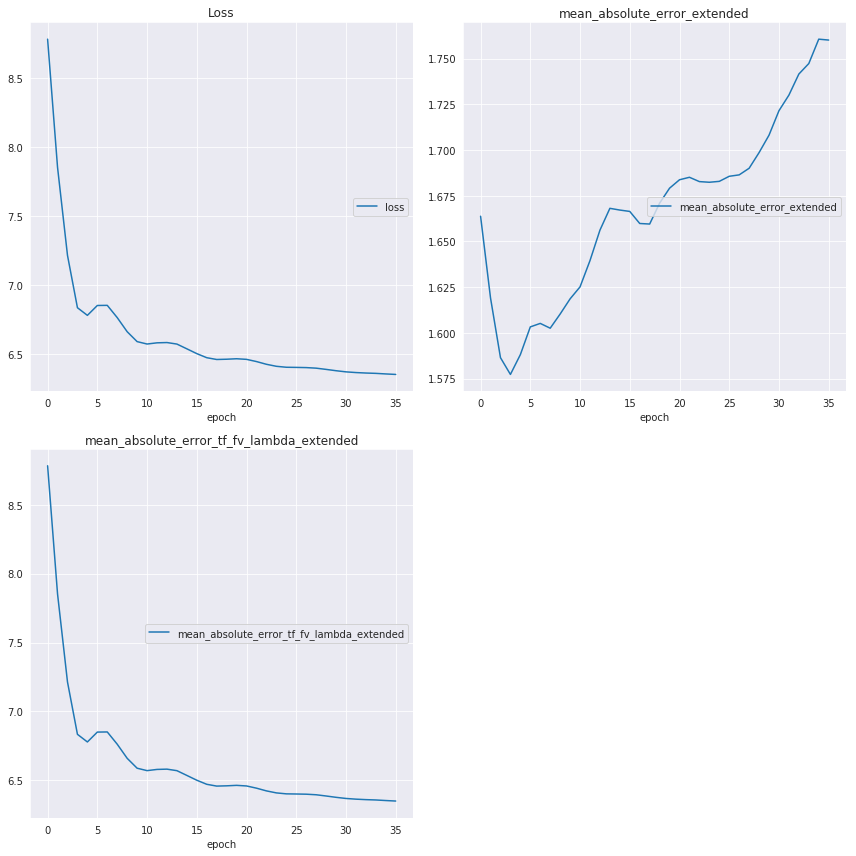

Loss
	loss             	 (min:    6.350, max:    8.783, cur:    6.350)
mean_absolute_error_extended
	mean_absolute_error_extended 	 (min:    1.577, max:    1.761, cur:    1.760)
mean_absolute_error_tf_fv_lambda_extended
	mean_absolute_error_tf_fv_lambda_extended 	 (min:    6.350, max:    8.783, cur:    6.350)


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [136]:
if not multi_epoch_analysis and samples_list == None or True: 
    
    results = train_nn_and_pred(X_train.values, 
                                X_valid.values, 
                                X_test.values, 
                                y_train.values, 
                                y_valid.values, 
                                y_test.values, 
                                lambda_train_fv_valid_split.values, 
                                lambda_train_fv_test_split.values, 
                                lambda_train_fv_train_split.values, 
                                lambda_valid_fv_valid_split.values, 
                                lambda_valid_fv_test_split.values, 
                                lambda_valid_fv_train_split.values, 
                                lambda_test_fv_valid_split.values, 
                                lambda_test_fv_test_split.values, 
                                lambda_test_fv_train_split.values, 
                                callback_names=['plot_losses_callback', 'early_stopping'], 
                                return_model=True)
    
    history = results[0]
    
    scores_complete = results[1]
    scores_with_valid_fv = scores_complete[0]
    scores_with_test_fv = scores_complete[1]
    
    polynomial_fv_complete = results[2]
    polynomial_valid_fv = polynomial_fv_complete[0]
    polynomial_test_fv = polynomial_fv_complete[1]
    
    model = results[3]
    
    x = PrettyTable()

    x.field_names = ["Error Name", "Valid Error Int", "Test Error Int"]

    for error, value in scores_with_test_fv.items():

        x.add_row([error, value[0], value[1]])

    print(x)    
    
elif multi_epoch_analysis and samples_list == None: 
    
    results_list = Parallel(n_jobs=n_jobs, 
                            verbose=11, 
                            backend='loky')(delayed(train_nn_and_pred)(X_train.values, 
                                                                      X_valid.values, 
                                                                      X_test.values, 
                                                                      y_train.values, 
                                                                      y_valid.values, 
                                                                      y_test.values, 
                                                                      lambda_train_fv_valid_split.values, 
                                                                      lambda_train_fv_test_split.values, 
                                                                      lambda_train_fv_train_split.values, 
                                                                      lambda_valid_fv_valid_split.values, 
                                                                      lambda_valid_fv_test_split.values, 
                                                                      lambda_valid_fv_train_split.values, 
                                                                      lambda_test_fv_valid_split.values, 
                                                                      lambda_test_fv_test_split.values, 
                                                                      lambda_test_fv_train_split.values, 
                                                                      callback_names=['early_stopping']) for X_train, 
                                                                                                               X_valid, 
                                                                                                               X_test, 
                                                                                                               y_train, 
                                                                                                               y_valid, 
                                                                                                               y_test, 
                                                                                                               lambda_train_fv_valid_split, 
                                                                                                               lambda_train_fv_test_split, 
                                                                                                               lambda_train_fv_train_split,                                            
                                                                                                               lambda_valid_fv_valid_split, 
                                                                                                               lambda_valid_fv_test_split, 
                                                                                                               lambda_valid_fv_train_split, 
                                                                                                               lambda_test_fv_valid_split, 
                                                                                                               lambda_test_fv_test_split, 
                                                                                                               lambda_test_fv_train_split in zip(X_train_list, 
                                                                                                                                                 X_valid_list, 
                                                                                                                                                 X_test_list, 
                                                                                                                                                 y_train_list, 
                                                                                                                                                 y_valid_list, 
                                                                                                                                                 y_test_list, 
                                                                                                                                                 lambda_train_fv_valid_split_list, 
                                                                                                                                                 lambda_train_fv_test_split_list, 
                                                                                                                                                 lambda_train_fv_train_split_list,                                                                                                                                                  
                                                                                                                                                 lambda_valid_fv_valid_split_list, 
                                                                                                                                                 lambda_valid_fv_test_split_list, 
                                                                                                                                                 lambda_valid_fv_train_split_list, 
                                                                                                                                                 lambda_test_fv_valid_split_list, 
                                                                                                                                                 lambda_test_fv_test_split_list, 
                                                                                                                                                 lambda_test_fv_train_split_list))      

    history_list = [result[0] for result in results_list]
    
    scores_complete_list = [result[1] for result in results_list]
    scores_with_valid_fv_list = [scores[0] for scores in scores_complete_list]
    scores_with_test_fv_list = [scores[1] for scores in scores_complete_list]
    
    polynomial_fv_complete_list = [result[2] for result in results_list]
    polynomial_valid_fv_list = [polynomial[0] for polynomial in polynomial_fv_complete_list]
    polynomial_test_fv_list = [polynomial[1] for polynomial in polynomial_fv_complete_list]


    for i, history in enumerate(history_list):  
        index = (i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1

        try:
            # Create target Directory
            os.mkdir('./data/results/' + interpretation_network_string + filename + '/')
        except FileExistsError:
            pass
        
        plt.plot(history[list(history.keys())[1]])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
        plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
        plt.ylabel('metric')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/' + list(history.keys())[len(history.keys())//2+1] +  '_' + interpretation_network_string + filename + '_epoch_' + str(index).zfill(3) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(index).zfill(3) + '.png')    
        if i < len(history_list)-1:
            plt.clf()
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(scores_with_test_fv_list, f, protocol=2)   
        
elif not multi_epoch_analysis and  samples_list != None:
    
    results_list = Parallel(n_jobs=n_jobs, verbose=11, backend='loky')(delayed(train_nn_and_pred)(X_train.sample(n=samples, random_state=RANDOM_SEED).values, 
                                                                                                  X_valid.values, 
                                                                                                  X_test.values, 
                                                                                                  y_train.sample(n=samples, random_state=RANDOM_SEED).values, 
                                                                                                  y_valid.values, 
                                                                                                  y_test.values, 
                                                                                                  lambda_train_fv_valid_split.values, 
                                                                                                  lambda_train_fv_test_split.values, 
                                                                                                  lambda_train_fv_train_split.values, 
                                                                                                  lambda_valid_fv_valid_split.values, 
                                                                                                  lambda_valid_fv_test_split.values, 
                                                                                                  lambda_valid_fv_train_split.values, 
                                                                                                  lambda_test_fv_valid_split.values, 
                                                                                                  lambda_test_fv_test_split.values, 
                                                                                                  lambda_test_fv_train_split.values, 
                                                                                                  callback_names=['early_stopping']) for samples in samples_list)     
    
    history_list = [result[0] for result in results_list]
     
    scores_complete_list = [result[1] for result in results_list]
    scores_with_valid_fv_list = [scores[0] for scores in scores_complete_list]
    scores_with_test_fv_list = [scores[1] for scores in scores_complete_list]
    
    polynomial_fv_complete_list = [result[2] for result in results_list]
    polynomial_valid_fv_list = [polynomial[0] for polynomial in polynomial_fv_complete_list]
    polynomial_test_fv_list = [polynomial[1] for polynomial in polynomial_fv_complete_list]

    for i, history in enumerate(history_list):       
        try:
            # Create target Directory
            os.mkdir('./data/results/' + interpretation_network_string + filename + '/')
        except FileExistsError:
            pass
        
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history[list(history.keys())[1]])
        plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
        plt.ylabel('metric')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/' + list(history.keys())[len(history.keys())//2+1] +  '_' + interpretation_network_string + filename + '_epoch_' + str(samples_list[i]).zfill(5) + '.png')
        plt.clf()
        
        plt.plot(history['loss'])
        if consider_labels_training or evaluate_with_real_function:
            plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(samples_list[i]).zfill(5) + '.png')    
        if i < len(history_list)-1:
            plt.clf()
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(history_list, f, protocol=2)   
        
    path = './data/results/' + interpretation_network_string + filename + '/history_' + interpretation_network_string + filename + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(scores_with_test_fv_list, f, protocol=2)     
        

## Evaluate Interpretation Net

In [ ]:
printer = None
if multi_epoch_analysis or samples_list != None:
    printer = scores_with_valid_fv_list[-1]
else:
    printer = scores_with_valid_fv
printer

In [ ]:
printer = None
if multi_epoch_analysis or samples_list != None:
    printer = scores_with_test_fv_list[-1]
else:
    printer = scores_with_test_fv
printer

In [ ]:
plt.plot(history[list(history.keys())[len(history.keys())//2+1]])
if consider_labels_training or evaluate_with_real_function:
    plt.plot(history[list(history.keys())[1]])
plt.title('model ' + list(history.keys())[len(history.keys())//2+1])
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./data/results/' + interpretation_network_string + filename + '/metric_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [ ]:
plt.plot(history['loss'])
if consider_labels_training or evaluate_with_real_function:
    plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

In [ ]:
if multi_epoch_analysis and samples_list == None: 
    plot_history_loss = []
    plot_history_metric = []
    plot_history_val_loss = []
    plot_history_val_metric = []
        
    for history in history_list:
        plot_history_loss.append(history['loss'][-1])
        plot_history_metric.append(history[list(history.keys())[1]][-1])

        if consider_labels_training or evaluate_with_real_function:
            plot_history_val_loss.append(history['val_loss'][-1])
            plot_history_val_metric.append(history[list(history.keys())[len(history.keys())//2+1]][-1])


In [ ]:
if multi_epoch_analysis and samples_list == None: 
    plot_history_loss_df = pd.DataFrame(data=plot_history_loss, index=[(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in range(len(plot_history_loss))])
    if consider_labels_training or evaluate_with_real_function:
        plot_history_val_loss_df = pd.DataFrame(data=plot_history_val_loss, index=[(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in range(len(plot_history_val_loss))])
    
    plt.plot(plot_history_loss_df)
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(plot_history_val_loss_df)
    plt.title('Loss')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.savefig('./data/results/' + interpretation_network_string + filename + '/loss_' + interpretation_network_string + filename + '_total.eps')
    plt.show()

In [ ]:
if multi_epoch_analysis and samples_list == None: 
    plot_history_metric_df = pd.DataFrame(data=plot_history_metric, index=[(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in range(len(plot_history_metric))])
    if consider_labels_training or evaluate_with_real_function:
        plot_history_val_metric_df = pd.DataFrame(data=plot_history_val_metric, index=[(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in range(len(plot_history_val_metric))])
    
    plt.plot(plot_history_metric_df)
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(plot_history_val_metric_df)
    plt.title('Metric')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.savefig('./data/results/' + interpretation_network_string + filename + '/metric_' + interpretation_network_string + filename + '_total.eps')
    plt.show()

#### Structure Interpretation-Net Socres for Plotting

In [ ]:
metrics_coeff_keys = ['MAE', 'RMSE', 'MAPE', 'Accuracy', 'Accuracy Multilabel']
metrics_fv_keys = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

new_row_identifiers_coeff = ['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT']
new_row_identifiers_fv = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

if multi_epoch_analysis and evaluate_with_real_function:

    scores_coeff_valid = []
    scores_coeff_test = []

    scores_valid_list = []
    scores_test_list = []
    stds_list = []    
    means_list = []    
    for i, scores_int in enumerate(scores_with_test_fv_list):
        index = (i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1

        if i == 0:
            scores_coeff_valid = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID E' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST E' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list = pd.DataFrame([scores_int[score][0] for score in metrics_fv_keys], columns=['VALID PRED E' + str(index)], index=new_row_identifiers_fv)
            scores_test_list = pd.DataFrame([scores_int[score][1] for score in metrics_fv_keys], columns=['TEST PRED E' + str(index)], index=new_row_identifiers_fv)
            
            stds_list = pd.DataFrame(scores_int['STD FV PRED'], columns=['E' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED'])

            means_list = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['E' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED'])
  
        else:
            scores_coeff_valid_new = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID E' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test_new = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST E' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list_new = pd.DataFrame([scores_int[score][0] for score in metrics_fv_keys], columns=['VALID PRED E' + str(index)], index=new_row_identifiers_fv)
            scores_test_list_new = pd.DataFrame([scores_int[score][1] for score in metrics_fv_keys], columns=['TEST PRED E' + str(index)], index=new_row_identifiers_fv)
                       
            stds_list_new = pd.DataFrame(scores_int['STD FV PRED'], columns=['E' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED'])
            
            means_list_new = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['E' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED'])
            
            
            scores_coeff_valid = pd.concat([scores_coeff_valid, scores_coeff_valid_new],axis=1)  
            scores_coeff_test = pd.concat([scores_coeff_test, scores_coeff_test_new],axis=1)  
            
            scores_valid_list = pd.concat([scores_valid_list, scores_valid_list_new],axis=1)  
            scores_test_list = pd.concat([scores_test_list, scores_test_list_new],axis=1)  

            stds_list = pd.concat([stds_list, stds_list_new],axis=1)
            
            means_list = pd.concat([means_list, means_list_new],axis=1)  


elif multi_epoch_analysis and not evaluate_with_real_function:

    scores_coeff_valid = []
    scores_coeff_test = []


    scores_valid_list = []
    scores_test_list = []
    stds_list = []    
    means_list = []    
    for i, scores_int in enumerate(scores_with_test_fv_list):
        index = (i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1

        if i == 0:
            scores_coeff_valid = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID E' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST E' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list = pd.DataFrame([[scores_int[score][2], scores_int[score][0]] for score in metrics_fv_keys], columns=['VALID PRED E' + str(index), 'VALID POLY E' + str(index)], index=new_row_identifiers_fv)
            scores_test_list = pd.DataFrame([[scores_int[score][3], scores_int[score][1]] for score in metrics_fv_keys], columns=['TEST PRED E' + str(index), 'TEST POLY E' + str(index)], index=new_row_identifiers_fv)
            
            stds_list = pd.DataFrame(scores_int['STD FV PRED'], columns=['E' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED', 'std_function_valid_pred_lambda_fv', 'std_function_test_pred_lambda_fv'])
            
            means_list = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['E' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED', 'mean_function_valid_pred_lambda_fv', 'mean_function_test_pred_lambda_fv'])
        else:
            scores_coeff_valid_new = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID E' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test_new = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST E' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list_new = pd.DataFrame([[scores_int[score][2], scores_int[score][0]] for score in metrics_fv_keys], columns=['VALID PRED E' + str(index), 'VALID POLY E' + str(index)], index=new_row_identifiers_fv)
            scores_test_list_new = pd.DataFrame([[scores_int[score][3], scores_int[score][1]] for score in metrics_fv_keys], columns=['TEST PRED E' + str(index), 'TEST POLY E' + str(index)], index=new_row_identifiers_fv)
                       
            stds_list_new = pd.DataFrame(scores_int['STD FV PRED'], columns=['E' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED', 'std_function_valid_pred_lambda_fv', 'std_function_test_pred_lambda_fv'])
            
            means_list_new = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['E' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED', 'mean_function_valid_pred_lambda_fv', 'means_function_test_pred_lambda_fv'])
            
            
            scores_coeff_valid = pd.concat([scores_coeff_valid, scores_coeff_valid_new],axis=1)  
            scores_coeff_test = pd.concat([scores_coeff_test, scores_coeff_test_new],axis=1)  
            
            scores_valid_list = pd.concat([scores_valid_list, scores_valid_list_new],axis=1)  
            scores_test_list = pd.concat([scores_test_list, scores_test_list_new],axis=1)  

            stds_list = pd.concat([stds_list, stds_list_new],axis=1)  
            
            means_list = pd.concat([means_list, means_list_new],axis=1)  
    
elif not multi_epoch_analysis and samples_list != None and evaluate_with_real_function:
    scores_coeff_valid = []
    scores_coeff_test = []


    scores_valid_list = []
    scores_test_list = []
    stds_list = []    
    means_list = []    

    for index, scores_int in enumerate(scores_with_test_fv_list):
        index = samples_list[index]
        
        if index == samples_list[0]:
            scores_coeff_valid = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID S' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST S' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list = pd.DataFrame([scores_int[score][0] for score in metrics_fv_keys], columns=['VALID PRED S' + str(index)], index=new_row_identifiers_fv)
            scores_test_list = pd.DataFrame([scores_int[score][1] for score in metrics_fv_keys], columns=['TEST PRED S' + str(index)], index=new_row_identifiers_fv)
            
            stds_list = pd.DataFrame(scores_int['STD FV PRED'], columns=['S' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED'])
            
            means_list = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['S' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED'])
        else:
            scores_coeff_valid_new = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID S' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test_new = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST S' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list_new = pd.DataFrame([scores_int[score][0] for score in metrics_fv_keys], columns=['VALID PRED S' + str(index)], index=new_row_identifiers_fv)
            scores_test_list_new = pd.DataFrame([scores_int[score][1] for score in metrics_fv_keys], columns=['TEST PRED S' + str(index)], index=new_row_identifiers_fv)
                       
            stds_list_new = pd.DataFrame(scores_int['STD FV PRED'], columns=['S' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED'])
            
            means_list_new = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['S' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED'])

            
            scores_coeff_valid = pd.concat([scores_coeff_valid, scores_coeff_valid_new],axis=1)  
            scores_coeff_test = pd.concat([scores_coeff_test, scores_coeff_test_new],axis=1)  
            
            scores_valid_list = pd.concat([scores_valid_list, scores_valid_list_new],axis=1)  
            scores_test_list = pd.concat([scores_test_list, scores_test_list_new],axis=1)  

            stds_list = pd.concat([stds_list, stds_list_new],axis=1) 
            
            means_list = pd.concat([means_list, means_list_new],axis=1)     
            
elif not multi_epoch_analysis and  samples_list != None and not evaluate_with_real_function:

    scores_coeff_valid = []
    scores_coeff_test = []


    scores_valid_list = []
    scores_test_list = []
    stds_list = []    
    means_list = []    
    for index, scores_int in enumerate(scores_with_test_fv_list):
        index = samples_list[index]

        if index == samples_list[0]:
            scores_coeff_valid = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID S' + str(index)], index=new_row_identifiers_coeff)
            scores_coeff_test = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST S' + str(index)], index=new_row_identifiers_coeff)
            
            scores_valid_list = pd.DataFrame([[scores_int[score][2], scores_int[score][0]] for score in metrics_fv_keys], columns=['VALID PRED S' + str(index), 'VALID POLY S' + str(index)], index=new_row_identifiers_fv)
            scores_test_list = pd.DataFrame([[scores_int[score][3], scores_int[score][1]] for score in metrics_fv_keys], columns=['TEST PRED S' + str(index), 'TEST POLY S' + str(index)], index=new_row_identifiers_fv)
            
            stds_list = pd.DataFrame(scores_int['STD FV PRED'], columns=['S' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED', 'std_function_valid_pred_lambda_fv', 'std_function_test_pred_lambda_fv'])
            
            means_list = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['S' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED', 'mean_function_valid_pred_lambda_fv', 'mean_function_test_pred_lambda_fv'])

        else:
            scores_coeff_valid_new = pd.DataFrame([scores_int[score][0] for score in metrics_coeff_keys], columns=['VALID S' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            scores_coeff_test_new = pd.DataFrame([scores_int[score][1] for score in metrics_coeff_keys], columns=['TEST S' + str(index)], index=['MAE', 'RMSE', 'MAPE', 'ACC', 'ACC MULT'])
            
            scores_valid_list_new = pd.DataFrame([[scores_int[score][2], scores_int[score][0]] for score in metrics_fv_keys], columns=['VALID PRED S' + str(index), 'VALID POLY S' + str(index)], index=new_row_identifiers_fv)
            scores_test_list_new = pd.DataFrame([[scores_int[score][3], scores_int[score][1]] for score in metrics_fv_keys], columns=['TEST PRED S' + str(index), 'TEST POLY S' + str(index)], index=new_row_identifiers_fv)
                       
            stds_list_new = pd.DataFrame(scores_int['STD FV PRED'], columns=['S' + str(index)], index=['STD FUNC VALID PRED', 'STD FUNC TEST PRED', 'std_function_valid_pred_lambda_fv', 'std_function_test_pred_lambda_fv'])

            means_list_new = pd.DataFrame(scores_int['MEAN FV PRED'], columns=['S' + str(index)], index=['MEAN FUNC VALID PRED', 'MEAN FUNC TEST PRED', 'mean_function_valid_pred_lambda_fv', 'mean_function_test_pred_lambda_fv'])
            
            
            scores_coeff_valid = pd.concat([scores_coeff_valid, scores_coeff_valid_new],axis=1)  
            scores_coeff_test = pd.concat([scores_coeff_test, scores_coeff_test_new],axis=1)  
            
            scores_valid_list = pd.concat([scores_valid_list, scores_valid_list_new],axis=1)  
            scores_test_list = pd.concat([scores_test_list, scores_test_list_new],axis=1)  

            stds_list = pd.concat([stds_list, stds_list_new],axis=1)      
            
            means_list = pd.concat([means_list, means_list_new],axis=1)    
            
if multi_epoch_analysis:            
    path_scores_valid_coef_int = './data/results/' + interpretation_network_string + filename + '/scores_valid_multiepoch_coef_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
    path_scores_test_coef_int = './data/results/' + interpretation_network_string + filename + '/scores_test_multiepoch_coef_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_scores_valid_int = './data/results/' + interpretation_network_string + filename + '/scores_valid_multiepoch_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
    path_scores_test_int = './data/results/' + interpretation_network_string + filename + '/scores_test_multiepoch_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_stds_int = './data/results/' + interpretation_network_string + filename + '/stds_multiepoch_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_means_int = './data/results/' + interpretation_network_string + filename + '/means_multiepoch_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'


    scores_coeff_valid.to_csv(path_scores_valid_coef_int, sep=',')
    scores_coeff_test.to_csv(path_scores_test_coef_int, sep=',') 

    scores_valid_list.to_csv(path_scores_valid_int, sep=',')
    scores_test_list.to_csv(path_scores_test_int, sep=',')

    stds_list.to_csv(path_stds_int, sep=',')  
    means_list.to_csv(path_means_int, sep=',')  
elif samples_list != None:            
    path_scores_valid_coef_int = './data/results/' + interpretation_network_string + filename + '/scores_valid_samples_coef_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
    path_scores_test_coef_int = './data/results/' + interpretation_network_string + filename + '/scores_test_samples_coef_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_scores_valid_int = './data/results/' + interpretation_network_string + filename + '/scores_samples_valid_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'
    path_scores_test_int = './data/results/' + interpretation_network_string + filename + '/scores_samples_test_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_stds_int = './data/results/' + interpretation_network_string + filename + '/stds_samples_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'

    path_means_int = './data/results/' + interpretation_network_string + filename + '/means_samples_' + interpretation_network_string + filename + '_epoch_' + str(epochs_lambda).zfill(3) + '.txt'


    scores_coeff_valid.to_csv(path_scores_valid_coef_int, sep=',')
    scores_coeff_test.to_csv(path_scores_test_coef_int, sep=',') 

    scores_valid_list.to_csv(path_scores_valid_int, sep=',')
    scores_test_list.to_csv(path_scores_test_int, sep=',')

    stds_list.to_csv(path_stds_int, sep=',')  
    means_list.to_csv(path_means_int, sep=',')      

#### Load Lambda Scores for Plotting

In [ ]:
path_scores_valid_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_valid_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
path_scores_test_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_test_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
path_stds_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/stds_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
path_means_lambda = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/means_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'


df_mean_scores_valid_lambda = pd.read_csv(path_scores_valid_lambda, sep=',', index_col=0)
df_mean_scores_test_lambda = pd.read_csv(path_scores_test_lambda, sep=',', index_col=0)
df_stds_lambda = pd.read_csv(path_stds_lambda, sep=',', index_col=0)
df_means_lambda = pd.read_csv(path_means_lambda, sep=',', index_col=0)


In [ ]:
df_mean_scores_test_lambda

In [ ]:
df_stds_lambda

In [ ]:
df_means_lambda

### Select Columns to Plot

In [ ]:
if multi_epoch_analysis:
    'Reduce the dfs to equal keys for plotting comparison'
    plot_cols = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']
    scores_lambda = df_mean_scores_test_lambda.loc[plot_cols]
    scores_int = scores_test_list.loc[plot_cols]    
elif samples_list != None:
    'Reduce the dfs to equal keys for plotting comparison'
    plot_cols = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']
    scores_int = scores_test_list.loc[plot_cols] 
    scores_lambda = df_mean_scores_test_lambda.loc[plot_cols].iloc[:,-4:]

In [ ]:
print_head = None
if multi_epoch_analysis or samples_list != None:
    print_head = scores_int
print_head

In [ ]:
lambda_test_fv.head()

In [ ]:
lambda_valid_fv.head()

### Generate Comparison Plots

In [ ]:
#Generate plot TEST PRED
try:
    # Create target Directory
    os.mkdir('./data/plotting/' + interpretation_network_string + filename + '/')
except FileExistsError:
    pass

if multi_epoch_analysis and evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_cols)
    subplot_number = 1
    plt.figure(figsize=(12*2, 7*length_plt/2))

    #For plotting of the int net, only second value of the tuple can be used for the comparison. Thus, always
    #extract the second value from the scores_int df
    for index in scores_lambda.index:

        vals_int_real = scores_int.loc[index].values
        vals_lambda_real = scores_lambda.loc[index].values[::4]
        vals_lambda_lstsq = scores_lambda.loc[index].values[3::4]

        ax = plt.subplot(length_plt//2+1, 2, subplot_number)
        ax.set_title(index, fontsize=20)
        ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_int_real, label='Error I-Net Poly vs. Real Poly')
        ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_lambda_real, label='Error Lambda Model Preds vs. Real Poly')
        ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_lambda_lstsq, label='Error LSTSQ Preds vs. Real Poly')
        ax.legend(loc="bottom right", fontsize=14)
        ax.set_xlim([0, epochs_lambda])
        
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)   
            
        #ax.set_xticks(np.arange(0, epochs, step=1))
        subplot_number += 1
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'multi_epoch_REAL_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()
    
elif multi_epoch_analysis and not evaluate_with_real_function:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_cols)
    subplot_number = 1
    plt.figure(figsize=(12*2, 7*length_plt/2))

    #For plotting of the int net, only second value of the tuple can be used for the comparison. Thus, always
    #extract the second value from the scores_int df
    for index in scores_lambda.index:

        vals_int_poly = scores_int.loc[index].values[1::2]
        vals_int_preds = scores_int.loc[index].values[::2]
        vals_lambda_poly_pred = scores_lambda.loc[index].values[2::4]

        ax = plt.subplot(length_plt//2+1, 2, subplot_number)
        ax.set_title(index, fontsize=20)
        ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_int_poly, label='Error I-Net Poly vs Lambda Poly')
        ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_int_preds, label='Error I-Net Poly vs Lambda Model Preds')
        ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_lambda_poly_pred, label='Error Lambda Poly vs Lambda Model Preds')
        ax.legend(loc="bottom right", fontsize=14)
        ax.set_xlim([0, epochs_lambda])
        
        
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)   
                    
        #ax.set_xticks(np.arange(0, epochs, step=1))
        subplot_number += 1

    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'multi_epoch_MODEL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    plt.savefig(path, format='eps')
    plt.show()

elif samples_list != None and evaluate_with_real_function:
    length_plt = len(plot_cols)
    subplot_number = 1
    plt.figure(figsize=(12*2, 7*length_plt/2))

    #For plotting of the int net, only second value of the tuple can be used for the comparison. Thus, always
    #extract the second value from the scores_int df
    for index in scores_int.index:

        vals_int_real = scores_int.loc[index].values
        vals_lambda_real = np.concatenate([scores_lambda.loc[index].values[::4] for i in samples_list], axis=None)
        vals_lambda_lstsq = np.concatenate([scores_lambda.loc[index].values[3::4] for i in samples_list], axis=None)

        ax = plt.subplot(length_plt//2+1, 2, subplot_number)
        ax.set_title(index, fontsize=20)
        ax.plot(samples_list, vals_int_real, label='Error I-Net Poly vs. Real Poly')
        ax.plot(samples_list, vals_lambda_real, label='Error Lambda Model Preds vs. Real Poly')
        ax.plot(samples_list, vals_lambda_lstsq, label='Error LSTSQ Preds vs. Real Poly')
        ax.legend(loc="bottom right", fontsize=14)
        ax.set_xlim([0, samples_list[-1]])

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)   

        #ax.set_xticks(np.arange(0, epochs, step=1))
        subplot_number += 1
    
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file    
    
    plt.savefig(path, format='eps')
    plt.show()

elif samples_list != None and not evaluate_with_real_function:
    length_plt = len(plot_cols)
    subplot_number = 1
    plt.figure(figsize=(12*2, 7*length_plt/2))

    #For plotting of the int net, only second value of the tuple can be used for the comparison. Thus, always
    #extract the second value from the scores_int df
    for index in scores_int.index:

        vals_int_poly = scores_int.loc[index].values[1::2]
        vals_int_preds = scores_int.loc[index].values[::2]
        vals_lambda_poly_pred = np.concatenate([scores_lambda.loc[index].values[2::4] for i in samples_list], axis=None)
        
        ax = plt.subplot(length_plt//2+1, 2, subplot_number)
        ax.set_title(index, fontsize=20)
        ax.plot(samples_list, vals_int_poly, label='Error I-Net Poly vs Lambda Poly')
        ax.plot(samples_list, vals_int_preds, label='Error I-Net Poly vs Lambda Model Preds')
        ax.plot(samples_list, vals_lambda_poly_pred, label='Error Lambda Poly vs Lambda Model Preds')
        ax.legend(loc="bottom right", fontsize=14)
        ax.set_xlim([0, samples_list[-1]])

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)   

        #ax.set_xticks(np.arange(0, epochs, step=1))
        subplot_number += 1
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'sample_list' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file    
    
    plt.savefig(path, format='eps')
    plt.show()
        

In [ ]:
if multi_epoch_analysis and evaluate_with_real_function:
    index = 'MAE FV'

    vals_int_real = scores_int.loc[index].values
    vals_lambda_real = scores_lambda.loc[index].values[::4]
    vals_lambda_lstsq = scores_lambda.loc[index].values[3::4]


    fig, ax = plt.subplots(figsize=(12, 7))
    #ax.set_title('Accuracy Evaluation')

    ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_int_real, label='Error I-Net Poly vs. Real Poly')
    ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_lambda_real, label='Error Lambda Model Preds vs. Real Poly')
    ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_lambda_lstsq, label='Error LSTSQ Preds vs. Real Poly')

    ax.set_ylabel(index, fontsize=20)
    ax.set_xlabel('Epochs', fontsize=20)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)

    ax.legend(loc="bottom right", fontsize=15)
    ax.set_xlim([0, epochs_lambda])
    ax.set_ylim(bottom=0)
    #ax.set_xticks(np.arange(0, epochs, step=1))
    
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'multi_epoch_REAL_' + index + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file 
    
    fig.savefig(path, format='eps')
    
elif multi_epoch_analysis and not evaluate_with_real_function:
       
    index = 'MAE FV'

    vals_int_poly = scores_int.loc[index].values[1::2]
    vals_int_preds = scores_int.loc[index].values[::2]
    vals_lambda_poly_pred = scores_lambda.loc[index].values[2::4]


    fig, ax = plt.subplots(figsize=(12, 7))
    #ax.set_title('Accuracy Evaluation')

    ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_int_poly, label='Error I-Net Poly vs Lambda Poly')
    ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_int_preds, label='Error I-Net Poly vs Lambda Model Preds')
    ax.plot([(i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1 for i in epochs_save_range_lambda], vals_lambda_poly_pred, label='Error Lambda Poly vs Lambda Model Preds')

    ax.set_ylabel(index, fontsize=20)
    ax.set_xlabel('Epochs', fontsize=20)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)

    ax.legend(loc="bottom right", fontsize=15)
    ax.set_xlim([0, epochs_lambda])
    ax.set_ylim(bottom=0)
    
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'multi_epoch_MODEL_' + index + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
        
    fig.savefig(path, format='eps')

elif samples_list != None and evaluate_with_real_function:
    index = 'MAE FV'

    vals_int_real = scores_int.loc[index].values
    vals_lambda_real = np.concatenate([scores_lambda.loc[index].values[::4] for i in samples_list], axis=None)
    vals_lambda_lstsq = np.concatenate([scores_lambda.loc[index].values[3::4] for i in samples_list], axis=None)
        
    fig, ax = plt.subplots(figsize=(12, 7))
    
    ax.plot(samples_list, vals_int_real, label='Error I-Net Poly vs. Real Poly')
    ax.plot(samples_list, vals_lambda_real, label='Error Lambda Model Preds vs. Real Poly')
    ax.plot(samples_list, vals_lambda_lstsq, label='Error LSTSQ Preds vs. Real Poly')
        
    ax.set_ylabel(index, fontsize=20)
    ax.set_xlabel('Training Set Size I-Net', fontsize=20)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)   
    
    ax.legend(loc="bottom right", fontsize=15)
    ax.set_xlim([0, samples_list[-1]])
    ax.set_ylim(bottom=0)
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'sample_list_' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_REAL_' + index + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
    
    fig.savefig(path, format='eps')

elif samples_list != None and not evaluate_with_real_function:
    index = 'MAE FV'


    vals_int_poly = scores_int.loc[index].values[1::2]
    vals_int_preds = scores_int.loc[index].values[::2]
    vals_lambda_poly_pred = np.concatenate([scores_lambda.loc[index].values[2::4] for i in samples_list], axis=None)

        
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(samples_list, vals_int_poly, label='Error I-Net Poly vs Lambda Poly')
    ax.plot(samples_list, vals_int_preds, label='Error I-Net Poly vs Lambda Model Preds')
    ax.plot(samples_list, vals_lambda_poly_pred, label='Error Lambda Poly vs Lambda Model Preds')
    
    ax.set_ylabel(index, fontsize=20)
    ax.set_xlabel('Training Set Size I-Net', fontsize=20)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)   
    
    ax.legend(loc="bottom right", fontsize=15)
    ax.set_xlim([0, samples_list[-1]])
    ax.set_ylim(bottom=0)
    
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file = 'sample_list_' + '-'.join([str(samples_list[0]), str(samples_list[-1])]) +'_MODEL_' + index + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'

    path = location + folder + file
        
    fig.savefig(path, format='eps')


#### Generate and Analyze Predictions for Random Function

In [ ]:
if multi_epoch_analysis:
    plot_preds = polynomial_test_fv_list[-1]
    plot_eval = lambda_test_fv_test_split_list[-1]
elif samples_list != None:
    plot_preds = polynomial_test_fv_list[-1]
    plot_eval = lambda_test_fv_test_split
else:
    plot_preds = polynomial_test_fv
    plot_eval = lambda_test_fv_test_split

x_vars = ['x' + str(i) for i in range(1, n+1)]

columns = x_vars.copy()
columns.append('FVs')

columns_single = x_vars.copy()
columns_single.extend(['Real Poly FVs (Target)', 'Int Pred Poly FVs', 'Lambda Preds'])

eval_size_plot = plot_preds[2].shape[1]
rand_index = 2#42#random.randint(0, plot_preds[2].shape[0]-1)
vars_plot = np.column_stack([lambda_test_input[::,i] for i in range(n)])
plot_data_single = pd.DataFrame(data=np.column_stack([vars_plot, plot_preds[2][rand_index], plot_preds[3][rand_index], plot_eval.values[rand_index]]), columns=columns_single)

vars_plot_all_preds = np.append(np.append(vars_plot, vars_plot, axis=0), vars_plot, axis=0)
preds_plot_all = np.append(np.append(plot_preds[2][rand_index], plot_preds[3][rand_index], axis=0), plot_eval.values[rand_index], axis=0)

if evaluate_with_real_function:
    real_str = np.array(['Real Poly FVs (Target)' for i in range(eval_size_plot)])
    int_str = np.array(['Int Pred Poly FVs' for i in range(eval_size_plot)])
    lambda_str = np.array(['Lambda Preds' for i in range(eval_size_plot)])
    #Add Lambda Poly Preds LSTSQ
else:
    real_str = np.array(['Lambda Poly FVs (Target)' for i in range(eval_size_plot)])
    int_str = np.array(['Int Pred Poly FVs' for i in range(eval_size_plot)])
    lambda_str = np.array(['Lambda Preds' for i in range(eval_size_plot)])
    #Add Lambda Poly Preds
    
identifier = np.concatenate([real_str, int_str, lambda_str])

plot_data = pd.DataFrame(data=np.column_stack([vars_plot_all_preds, preds_plot_all]), columns=columns)
plot_data['Identifier'] = identifier



In [ ]:
pp1 = sns.pairplot(data=plot_data,
                  #kind='reg',
                  hue='Identifier',
                  y_vars=['FVs'],
                  x_vars=x_vars)

In [ ]:
pp2 = sns.pairplot(data=plot_data,
                  #kind='reg',
                  hue='Identifier',
                  #y_vars=['FVs'],
                  #x_vars=x_vars
                 )

In [ ]:
pp3 = sns.pairplot(data=plot_data_single,
                  #kind='reg',
                  y_vars=['Real Poly FVs (Target)', 'Int Pred Poly FVs', 'Lambda Preds'],
                  x_vars=x_vars)

In [ ]:
if evaluate_with_real_function:
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file1 = 'pp3in1_REAL_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file2 = 'pp3in1_extended_REAL_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file3 = 'pp1_REAL_' + str(rand_index) + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path1 = location + folder + file1
    path2 = location + folder + file2
    path3 = location + folder + file3
    
    pp1.savefig(path1, format='eps')
    pp2.savefig(path2, format='eps')
    pp3.savefig(path3, format='eps')
else:
    location = './data/plotting/'
    folder = interpretation_network_string + filename + '/'
    file1 = 'pp3in1_PRED_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file2 = 'pp3in1_extended_PRED_' + str(rand_index) + '_' + interpretation_network_string +  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    file3 = 'pp1_PRED_' + str(rand_index) + '_' + interpretation_network_string+  '_lambda_' + filename + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '.eps'
    
    path1 = location + folder + file1
    path2 = location + folder + file2
    path3 = location + folder + file3
    
    pp1.savefig(path1, format='eps')
    pp2.savefig(path2, format='eps')
    pp3.savefig(path3, format='eps')    
    

### Single Network Analysis

In [ ]:
if not multi_epoch_analysis and samples_list == None: 
    #%%script false --no-raise-error
    path_loss = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_loss_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_metric = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n)+ '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_metric_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_val_loss = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_val_loss_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'
    path_val_metric = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_val_metric_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs_lambda).zfill(3)  + filename + '.txt'


    loss_df_lambda = pd.read_csv(path_loss, sep=',')
    metric_df_lambda = pd.read_csv(path_metric, sep=',')
    val_loss_df_lambda = pd.read_csv(path_val_loss, sep=',')
    val_metric_df_lambda = pd.read_csv(path_val_metric, sep=',')


In [ ]:
if not multi_epoch_analysis and samples_list == None: 

    #%%script false --no-raise-error
    adjustment_threshold_metric = 0

    metric_df_adjusted = metric_df_lambda.copy(deep=True)
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])

    val_metric_df_adjusted = val_metric_df_lambda.copy(deep=True)
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])


    plt.plot(metric_df_adjusted.describe().loc['mean'].values)
    plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
    #plt.plot(random_network[2].history['val_metric'])
    plt.title('model metric')
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
if not multi_epoch_analysis and samples_list == None: 
    #%%script false --no-raise-error
    adjustment_threshold_loss = 1000

    loss_df_adjusted = loss_df_lambda.copy(deep=True)
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])

    val_loss_df_adjusted = val_loss_df_lambda.copy(deep=True)
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])


    plt.plot(loss_df_adjusted.describe().loc['mean'].values)
    plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
    #plt.plot(random_network[2].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()


In [ ]:
if not multi_epoch_analysis and samples_list == None: 
    preds = model.predict(X_test)
    preds_rounded = np.round(preds, 1)
    #preds_true = pd.DataFrame(data=[np.round(preds, 1), y_test.values])
    for pred, y in tqdm(zip(preds_rounded, y_test.values)):
        if (pred == y).all():
            print(pred)
    
    #print(preds_rounded)
    #print(y_test.values)

In [ ]:
#summarize history for loss
if not multi_epoch_analysis and samples_list == None: 
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    #plt.plot(random_network[2].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/loss_' + interpretation_network_string + filename + '.png')
    plt.show()
    

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = []
for i in range(y_test.shape[0]):
    random_polynomial = list(random_product([i*a_step for i in range(int(a_min*10**int(-np.log10(a_step))), int(a_max*10**int(-np.log10(a_step))))], repeat=nCr(n+d, d)))
    list_of_random_polynomials.append(random_polynomial)

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(y_test.values, lambda_test_input)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_test_input)

In [ ]:
print('Benchmark Error Coefficients: ' + str(np.round(mean_absolute_error(y_test, list_of_random_polynomials), 4)))

In [ ]:
print('Benchmark Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))